In [ ]:
# install distinctipy if not already installed
!pip install distinctipy -q

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import distinctipy

In [ ]:
# set the base directory path
BASE_DIR = "/content/drive/MyDrive/CSE 281"
ANALYSIS_DIR = os.path.join(BASE_DIR, "analysis")

# create analysis directory if it doesn't exist
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)
    print(f"Created analysis directory at: {ANALYSIS_DIR}")
else:
    print(f"Analysis directory already exists at: {ANALYSIS_DIR}")

# custom formatter function for x-axis labels
def custom_formatter(x, pos=None):
    date = mdates.num2date(x)
    if date.month in [3, 6, 9]:
        return date.strftime('%b')
    else:
        return ''

# set up matplotlib style for publication quality
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (14, 8),
    'axes.grid': True,
    'grid.alpha': 0.3
})

Analysis directory already exists at: /content/drive/MyDrive/CSE 281/analysis


In [ ]:
# load the DataFrame from the pickle file
df = pd.read_pickle("/content/drive/MyDrive/CSE 280/WattBuyData1999_2024.pkl")

# set start and end year
start_year = 2016
end_year = 2024

# initial filtering by year
df_filtered = df[(df['created_at'].dt.year >= start_year) &
                (df['created_at'].dt.year <= end_year)]

In [ ]:
# convert rates to dollars
df_filtered.loc[:, "utility_rate_amount"] = df_filtered["utility_rate_amount"] / 100
df_filtered.loc[:, "plan_rate_amount"] = df_filtered["plan_rate_amount"] / 100

# get data where utility_rate_type is default rate and supplier name exists
default_with_suppliers = df_filtered[
    (df_filtered['utility_rate_type'] == 'default rate')
].copy()

In [ ]:
# apply simplified filters
filtered_suppliers = default_with_suppliers[
     (default_with_suppliers['rate_type_plan'] == 'fixed') &
    (default_with_suppliers['term'] == 12.0) &
    (default_with_suppliers['service_type'] == 'residential') &
    ((default_with_suppliers['monthly_charge_amount'] == 0.0) |
     (default_with_suppliers['monthly_charge_amount'].isna())) &
    ((default_with_suppliers['early_term_fees_min_value'] == 0.0) |
     (default_with_suppliers['early_term_fees_min_value'].isna()))
].copy()

# remove complete duplicates
filtered_suppliers = filtered_suppliers.drop_duplicates()

In [ ]:
def impute_daily_data(group):
    utility_name = group['utility_name'].iloc[0]
    utility_rate_type = group['utility_rate_type'].iloc[0]

    # ensure no duplicate dates
    group = group.sort_values('created_at').drop_duplicates(subset='created_at', keep='last')

    start_date = group['created_at'].min()
    end_date = group['created_at'].max()

    # generate daily dates
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # set index and reindex
    group = group.set_index('created_at')
    group = group.reindex(daily_dates)

    # forward fill
    group = group.ffill()
    group = group.infer_objects(copy=False)

    # reset index and reassign keys
    group = group.reset_index().rename(columns={'index': 'created_at'})
    group['utility_name'] = utility_name
    group['utility_rate_type'] = utility_rate_type

    # flag imputed data
    group['is_imputed'] = ~group['created_at'].isin(default_with_suppliers['created_at'])

    return group

In [ ]:
# set pandas option to handle the warning
pd.set_option('future.no_silent_downcasting', True)

# process groups
grouped = default_with_suppliers.groupby(['utility_name', 'utility_rate_type'])
imputed_groups = []

for _, group in grouped:
    imputed_group = impute_daily_data(group)
    imputed_groups.append(imputed_group)

# combine and sort
df_imputed = pd.concat(imputed_groups, ignore_index=True)
df_combined = df_imputed.sort_values(['utility_name', 'utility_rate_type', 'created_at']).reset_index(drop=True)

In [ ]:
def plot_utility_monthly_rate_trend(utility_data, utility_name, utility_rate_type):
    # ensure datetime and resample to monthly
    utility_data['created_at'] = pd.to_datetime(utility_data['created_at'])
    utility_data = utility_data.set_index('created_at')
    monthly_data = utility_data.resample('MS').first().reset_index()
    monthly_data = monthly_data.sort_values(by='created_at')

    # create plot
    fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

    # plot data
    ax.plot(
        monthly_data['created_at'],
        monthly_data['utility_rate_amount'],
        label='Rate Amount',
        marker='o',
        linestyle='-',
        color='blue'
    )

    # format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

    plt.setp(ax.get_xticklabels(which='both'), rotation=90)

    # labels and title
    ax.set_xlabel('Year and Month', fontsize=12, fontweight='bold', labelpad=15)
    ax.set_ylabel('Rate Amount ($ per kWh)', fontsize=12, fontweight='bold')
    ax.set_title(f'{utility_name} - {utility_rate_type.title()} Rate Trend', fontsize=14, pad=20)

    # grid and legend
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    ax.legend()

    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(ANALYSIS_DIR, f"{utility_name.replace(' ', '_')}_rate_trend.png"),
                bbox_inches='tight',
                dpi=300)

    plt.show()

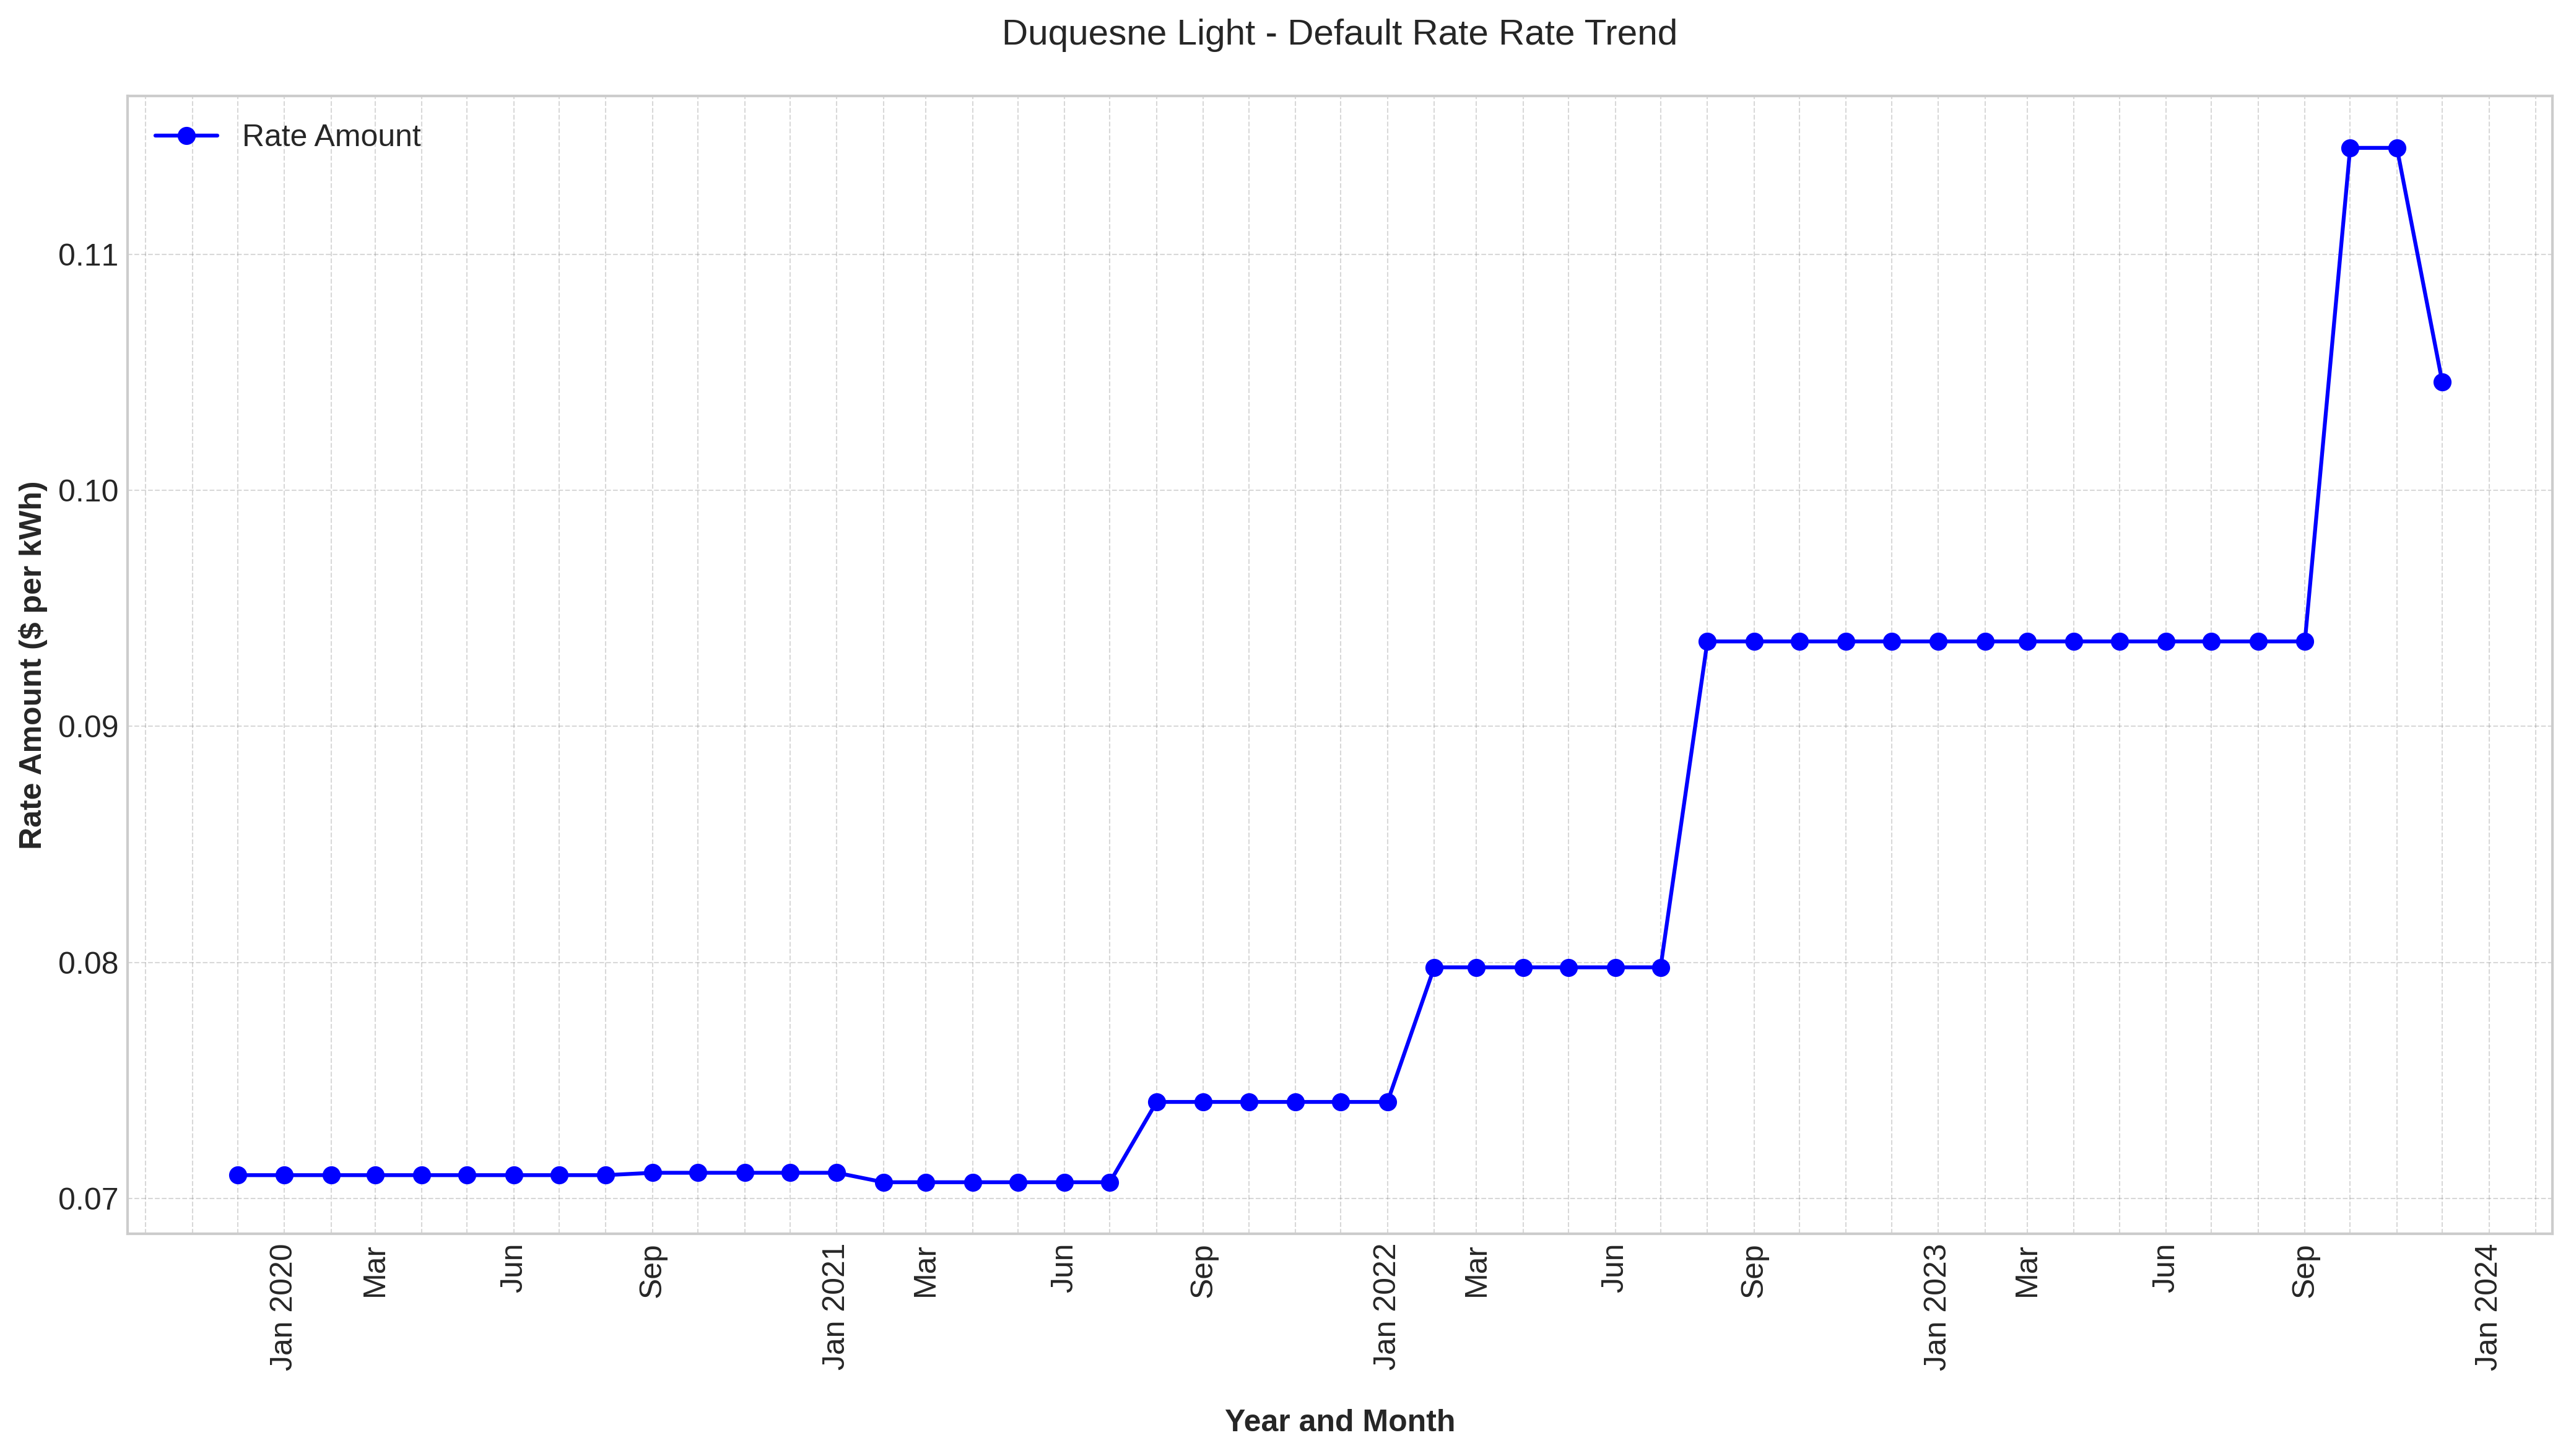

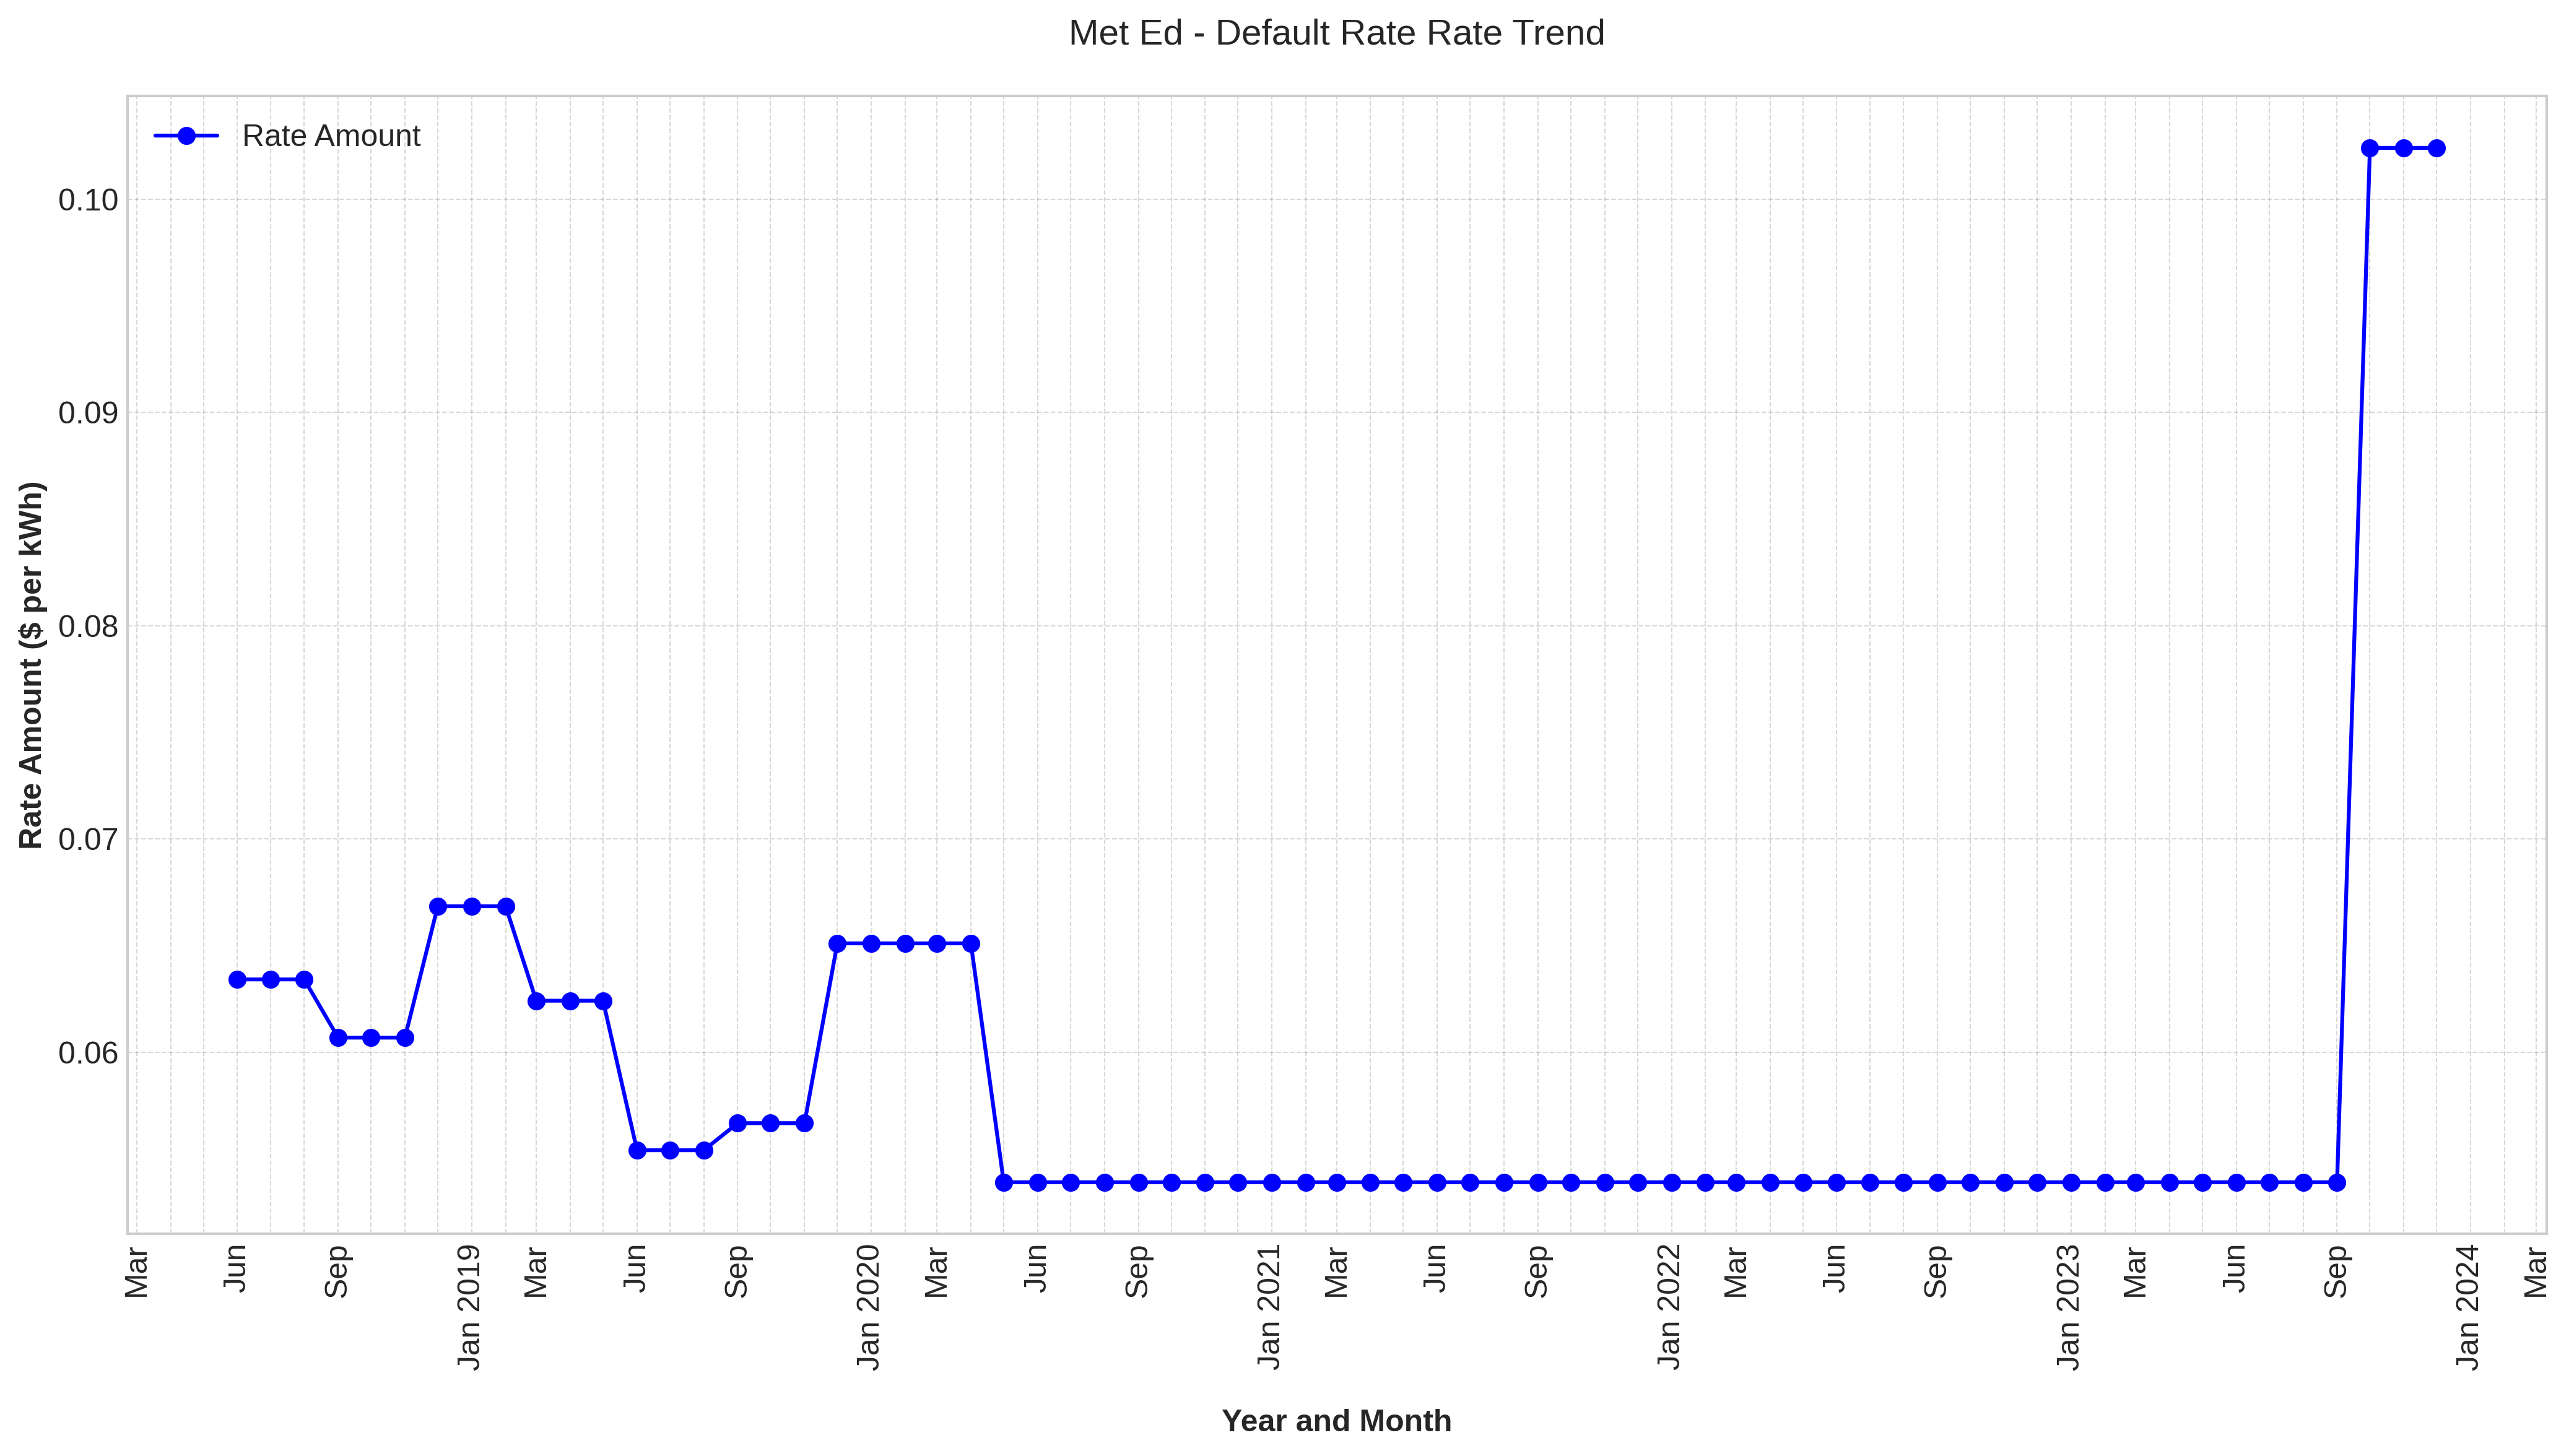

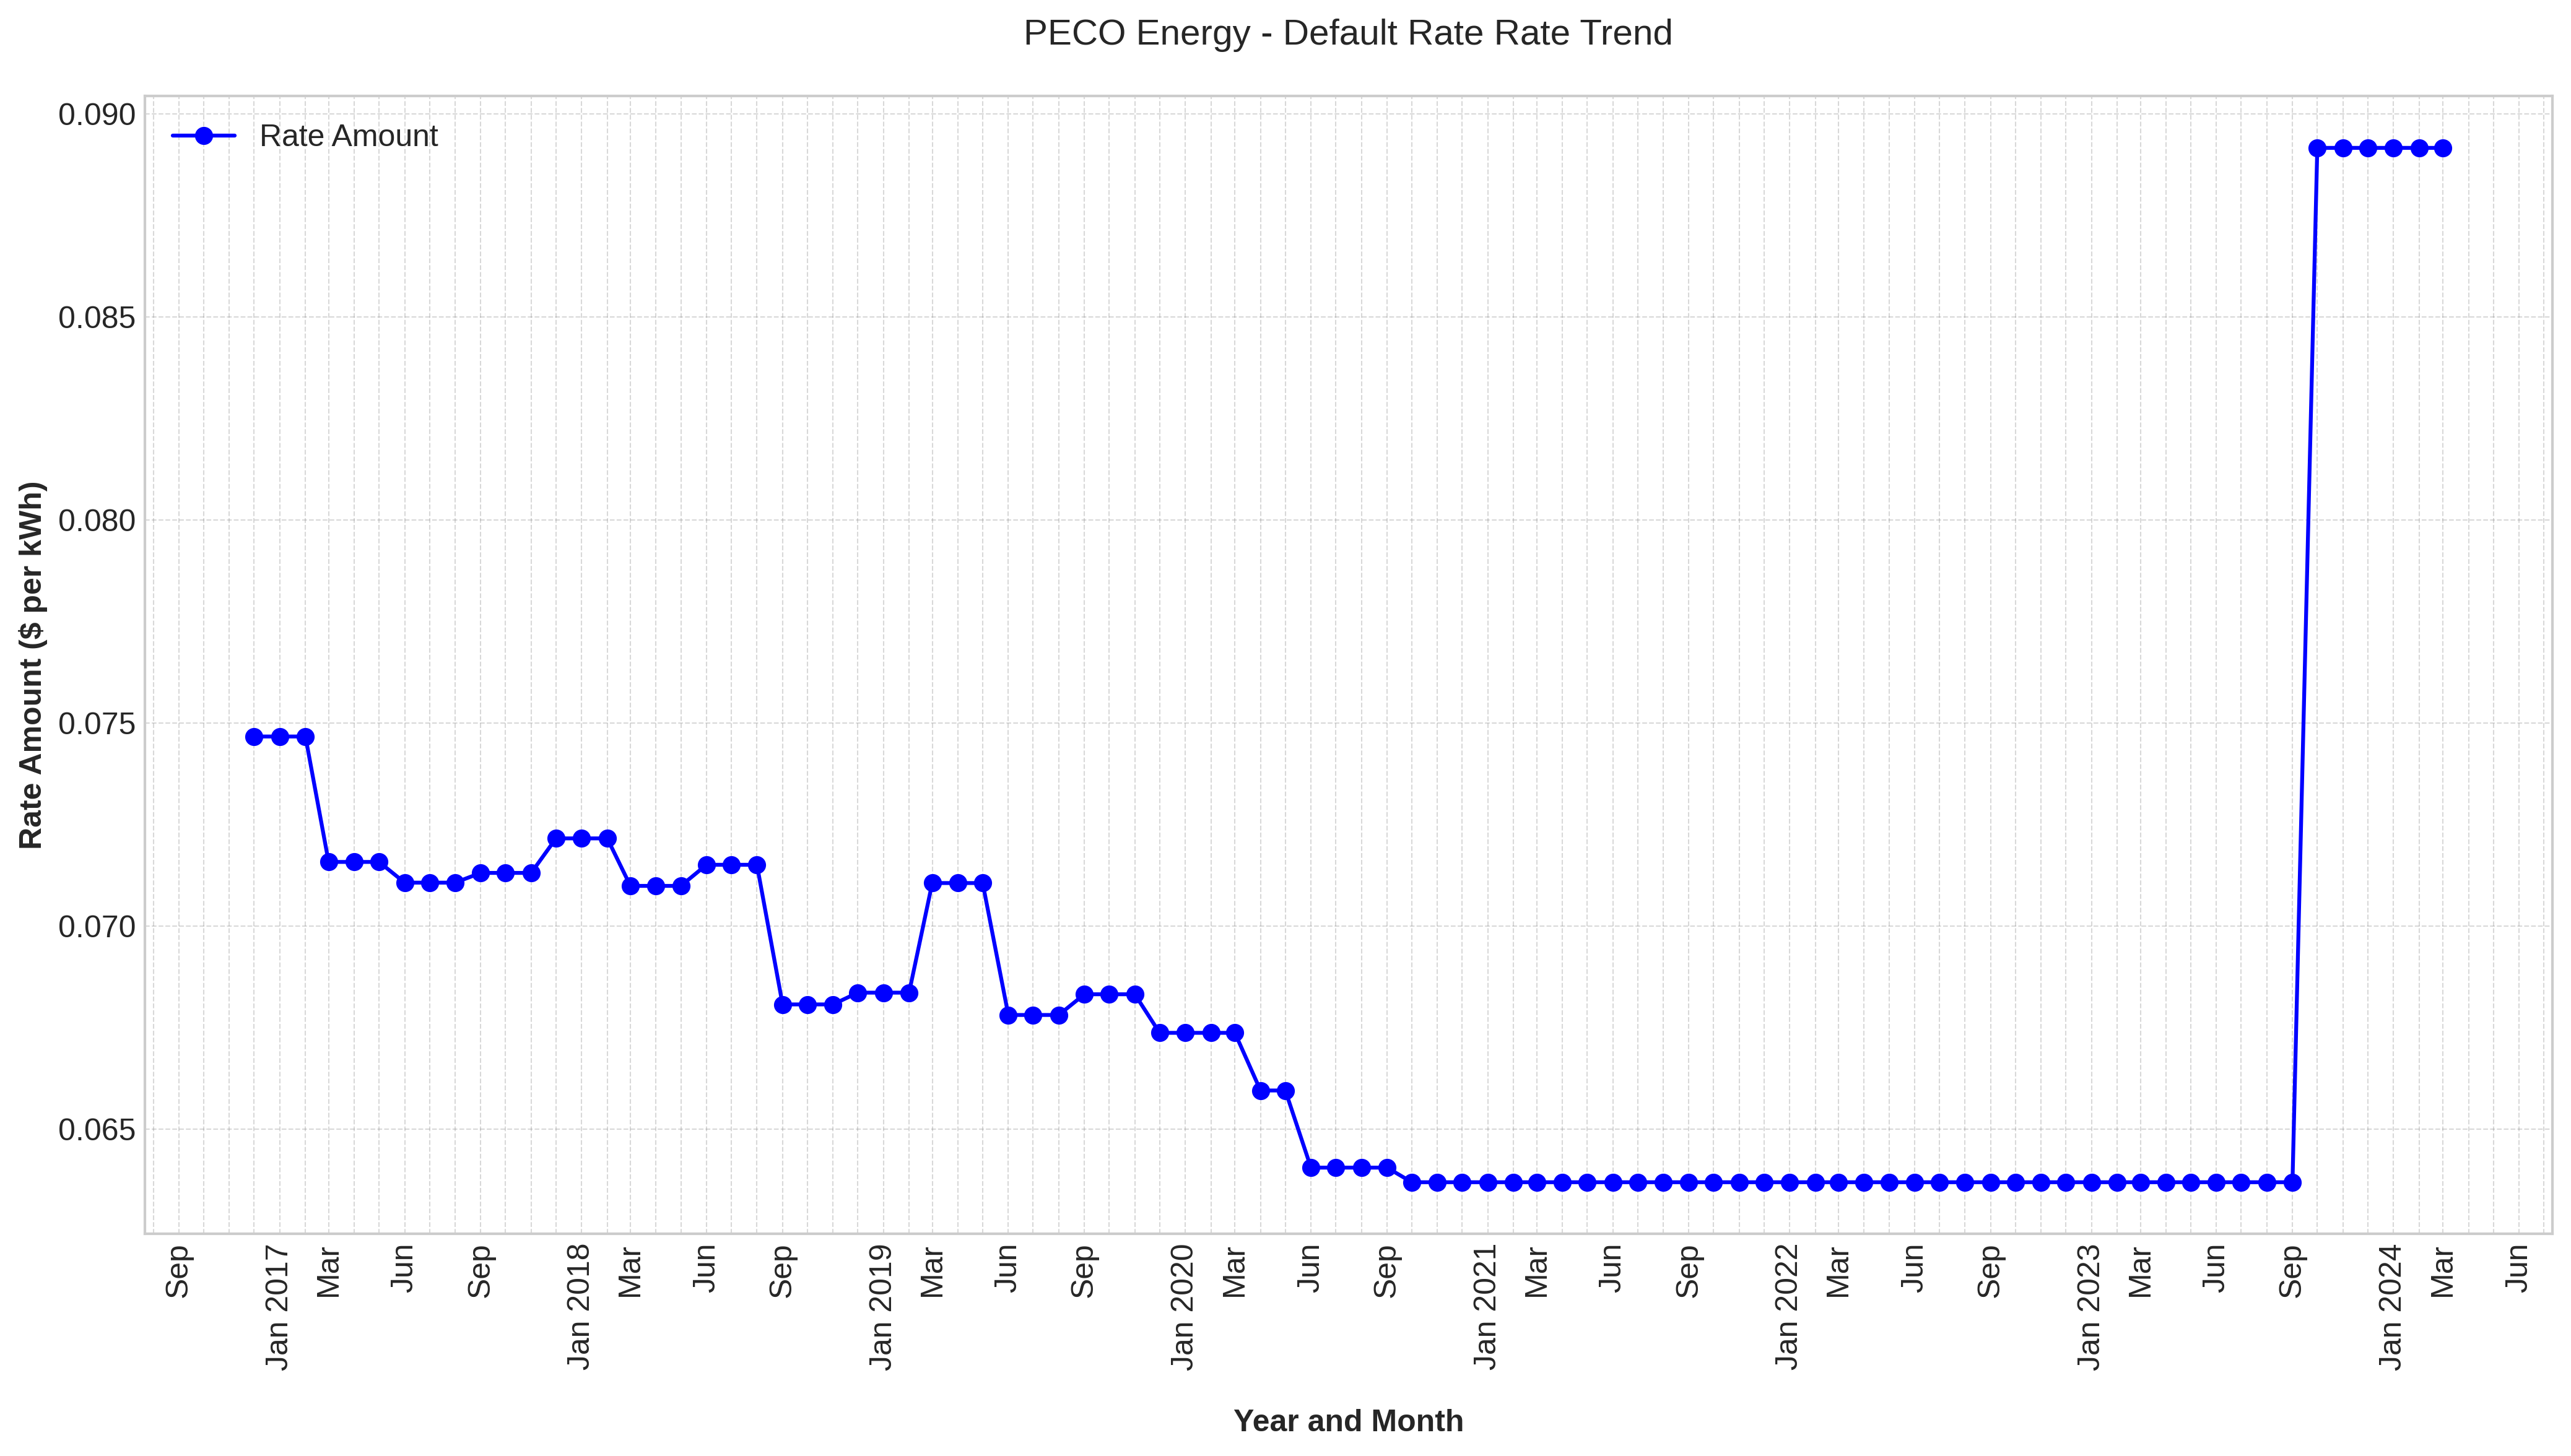

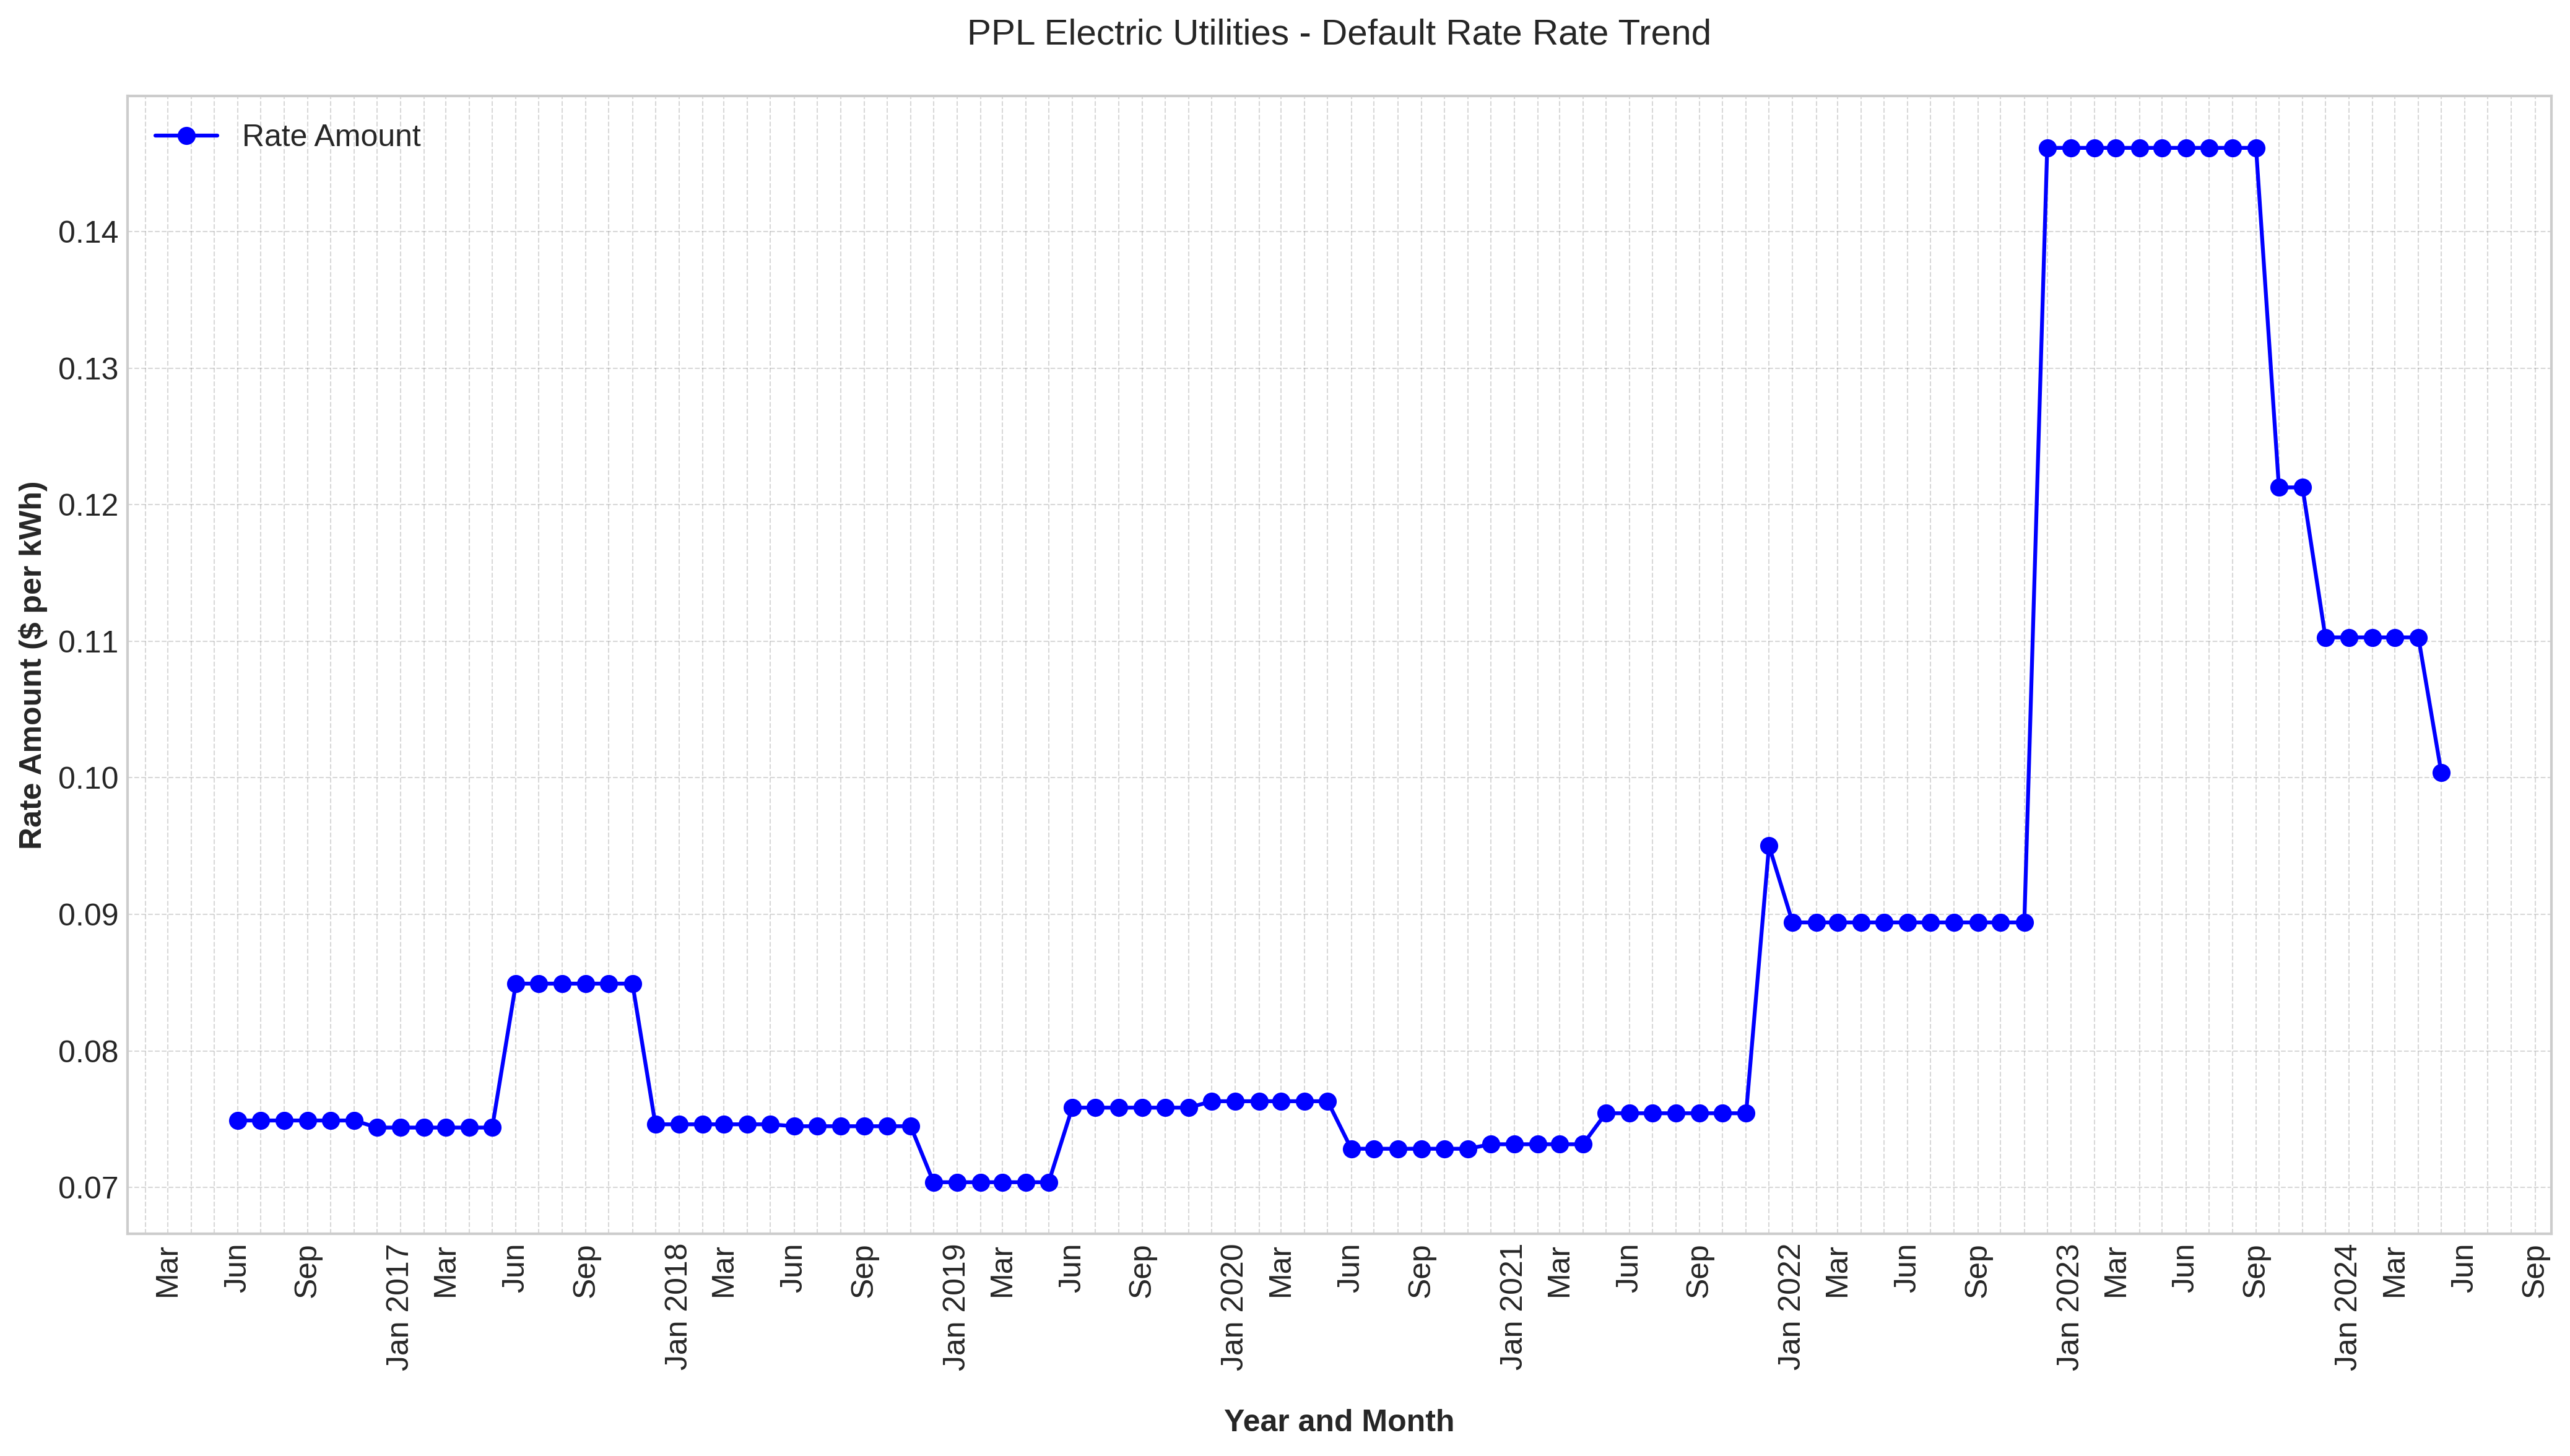

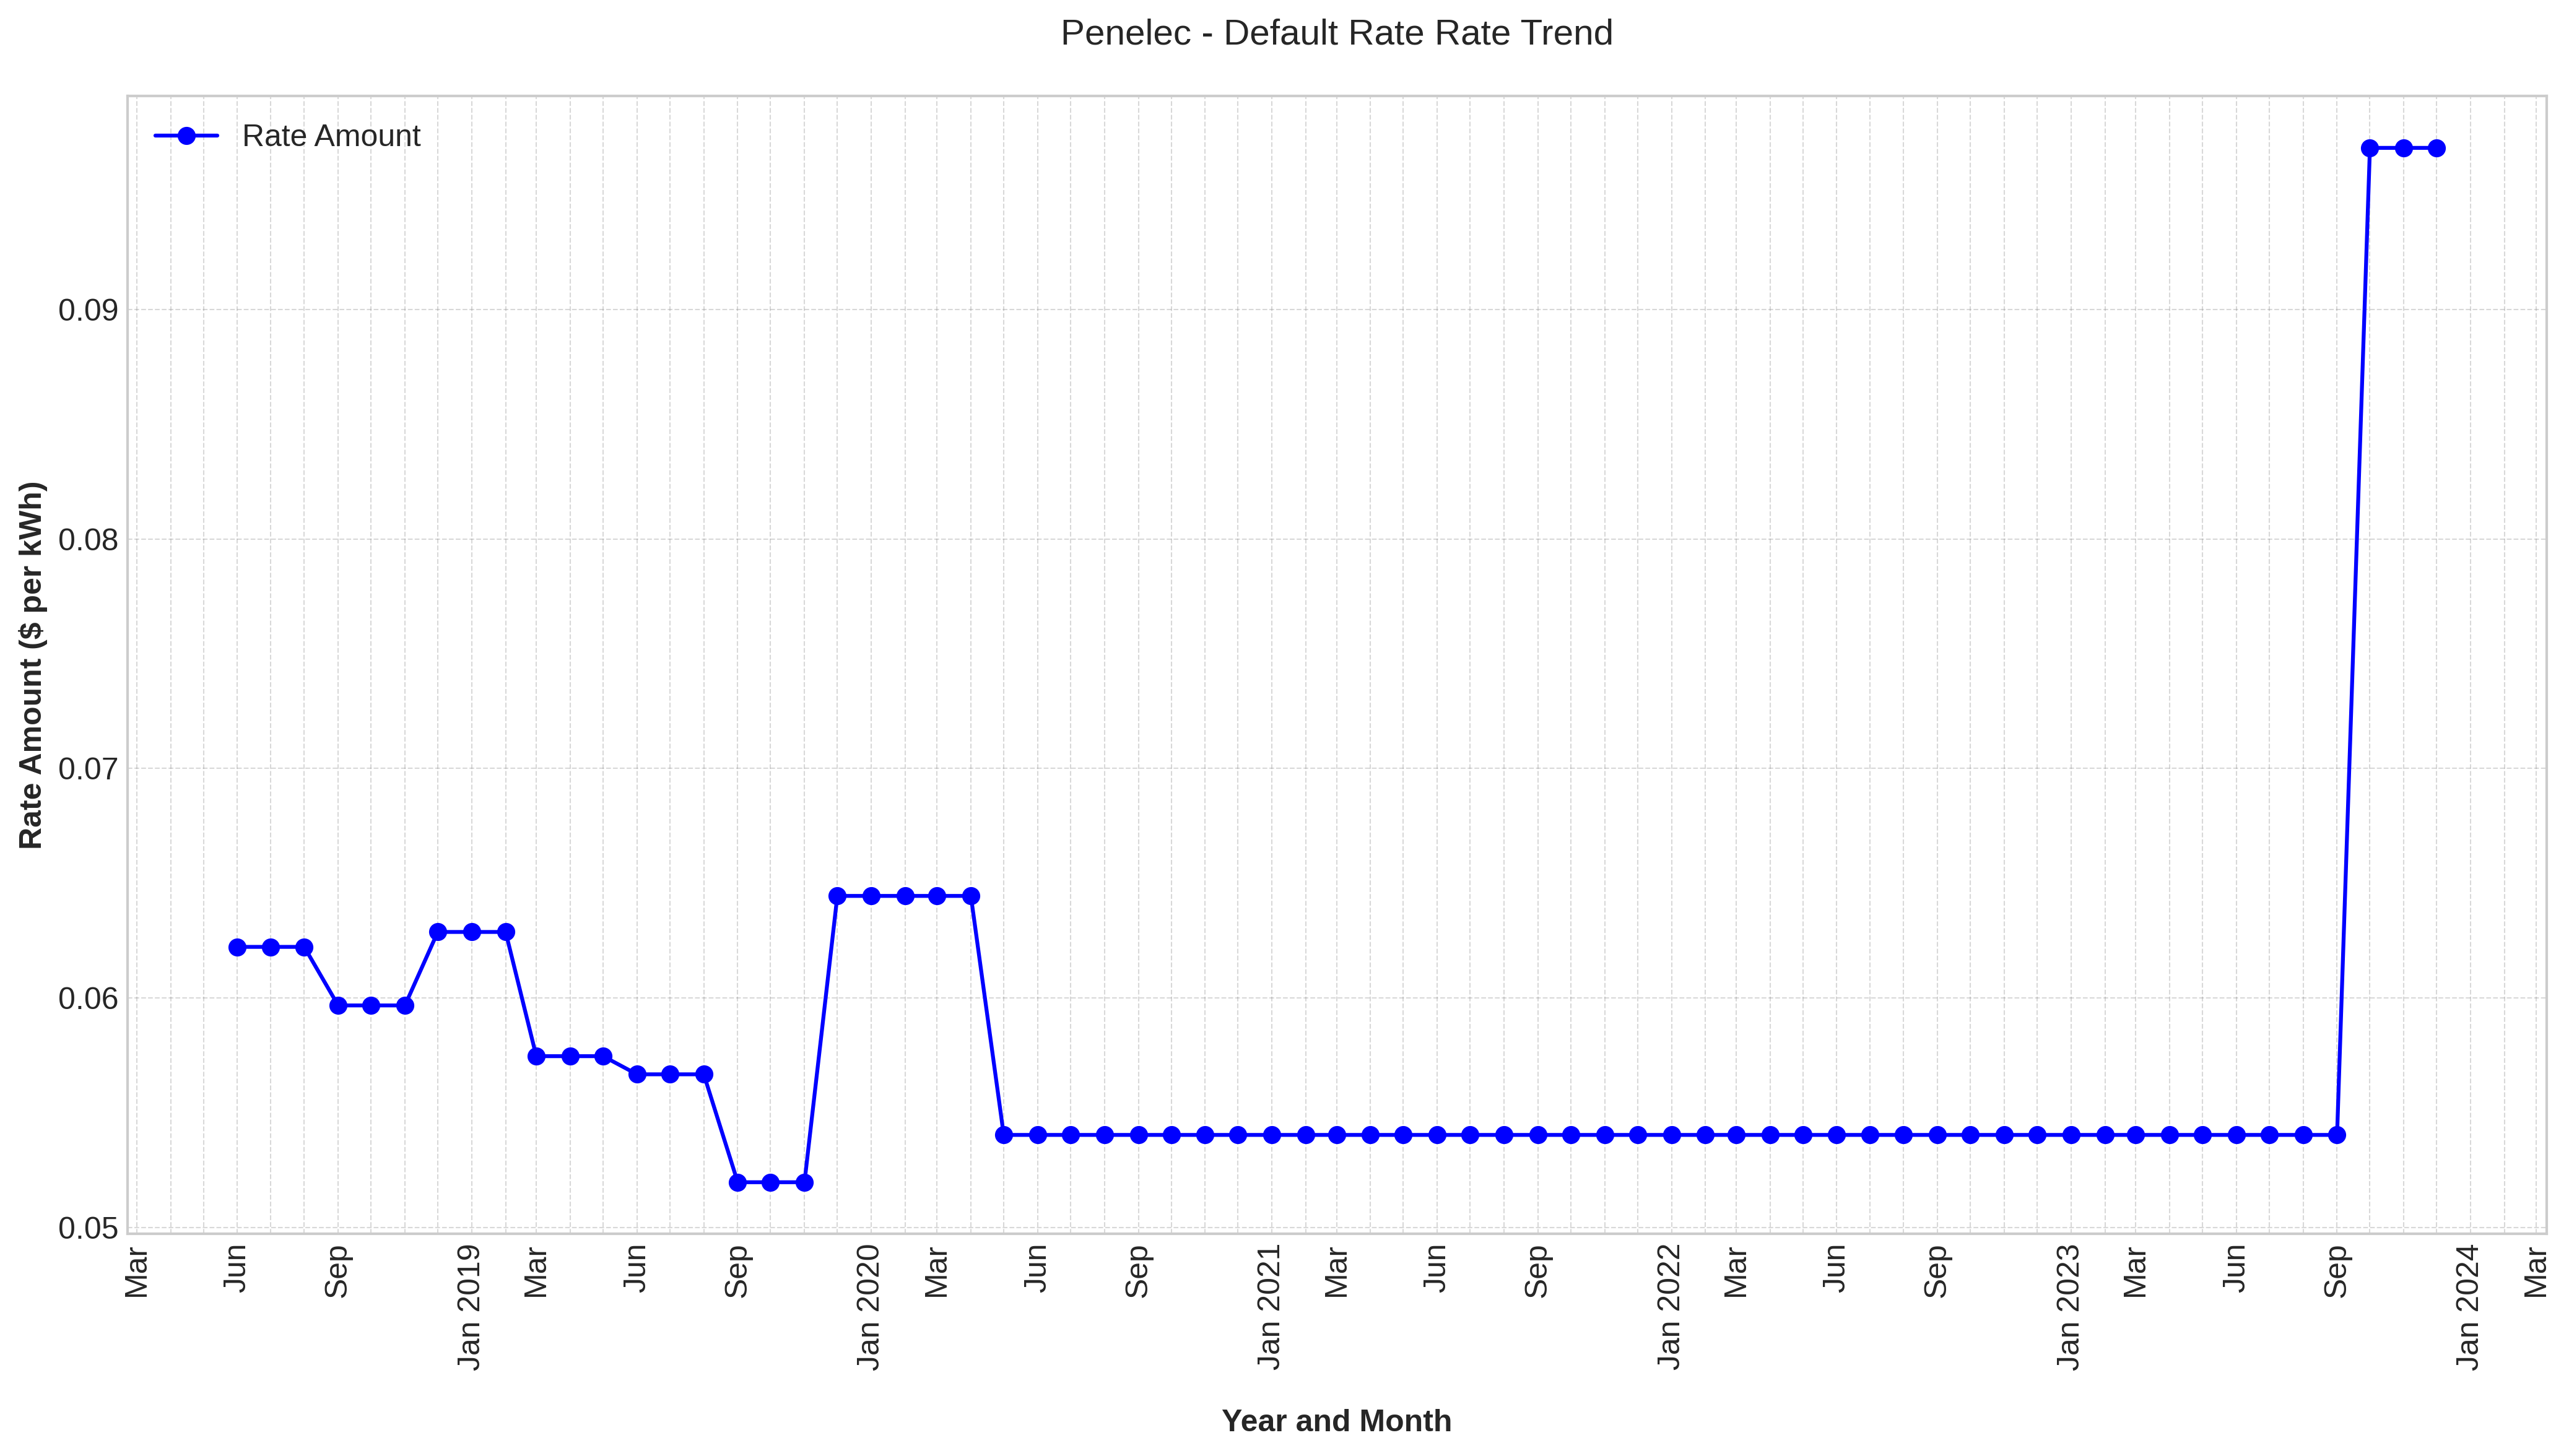

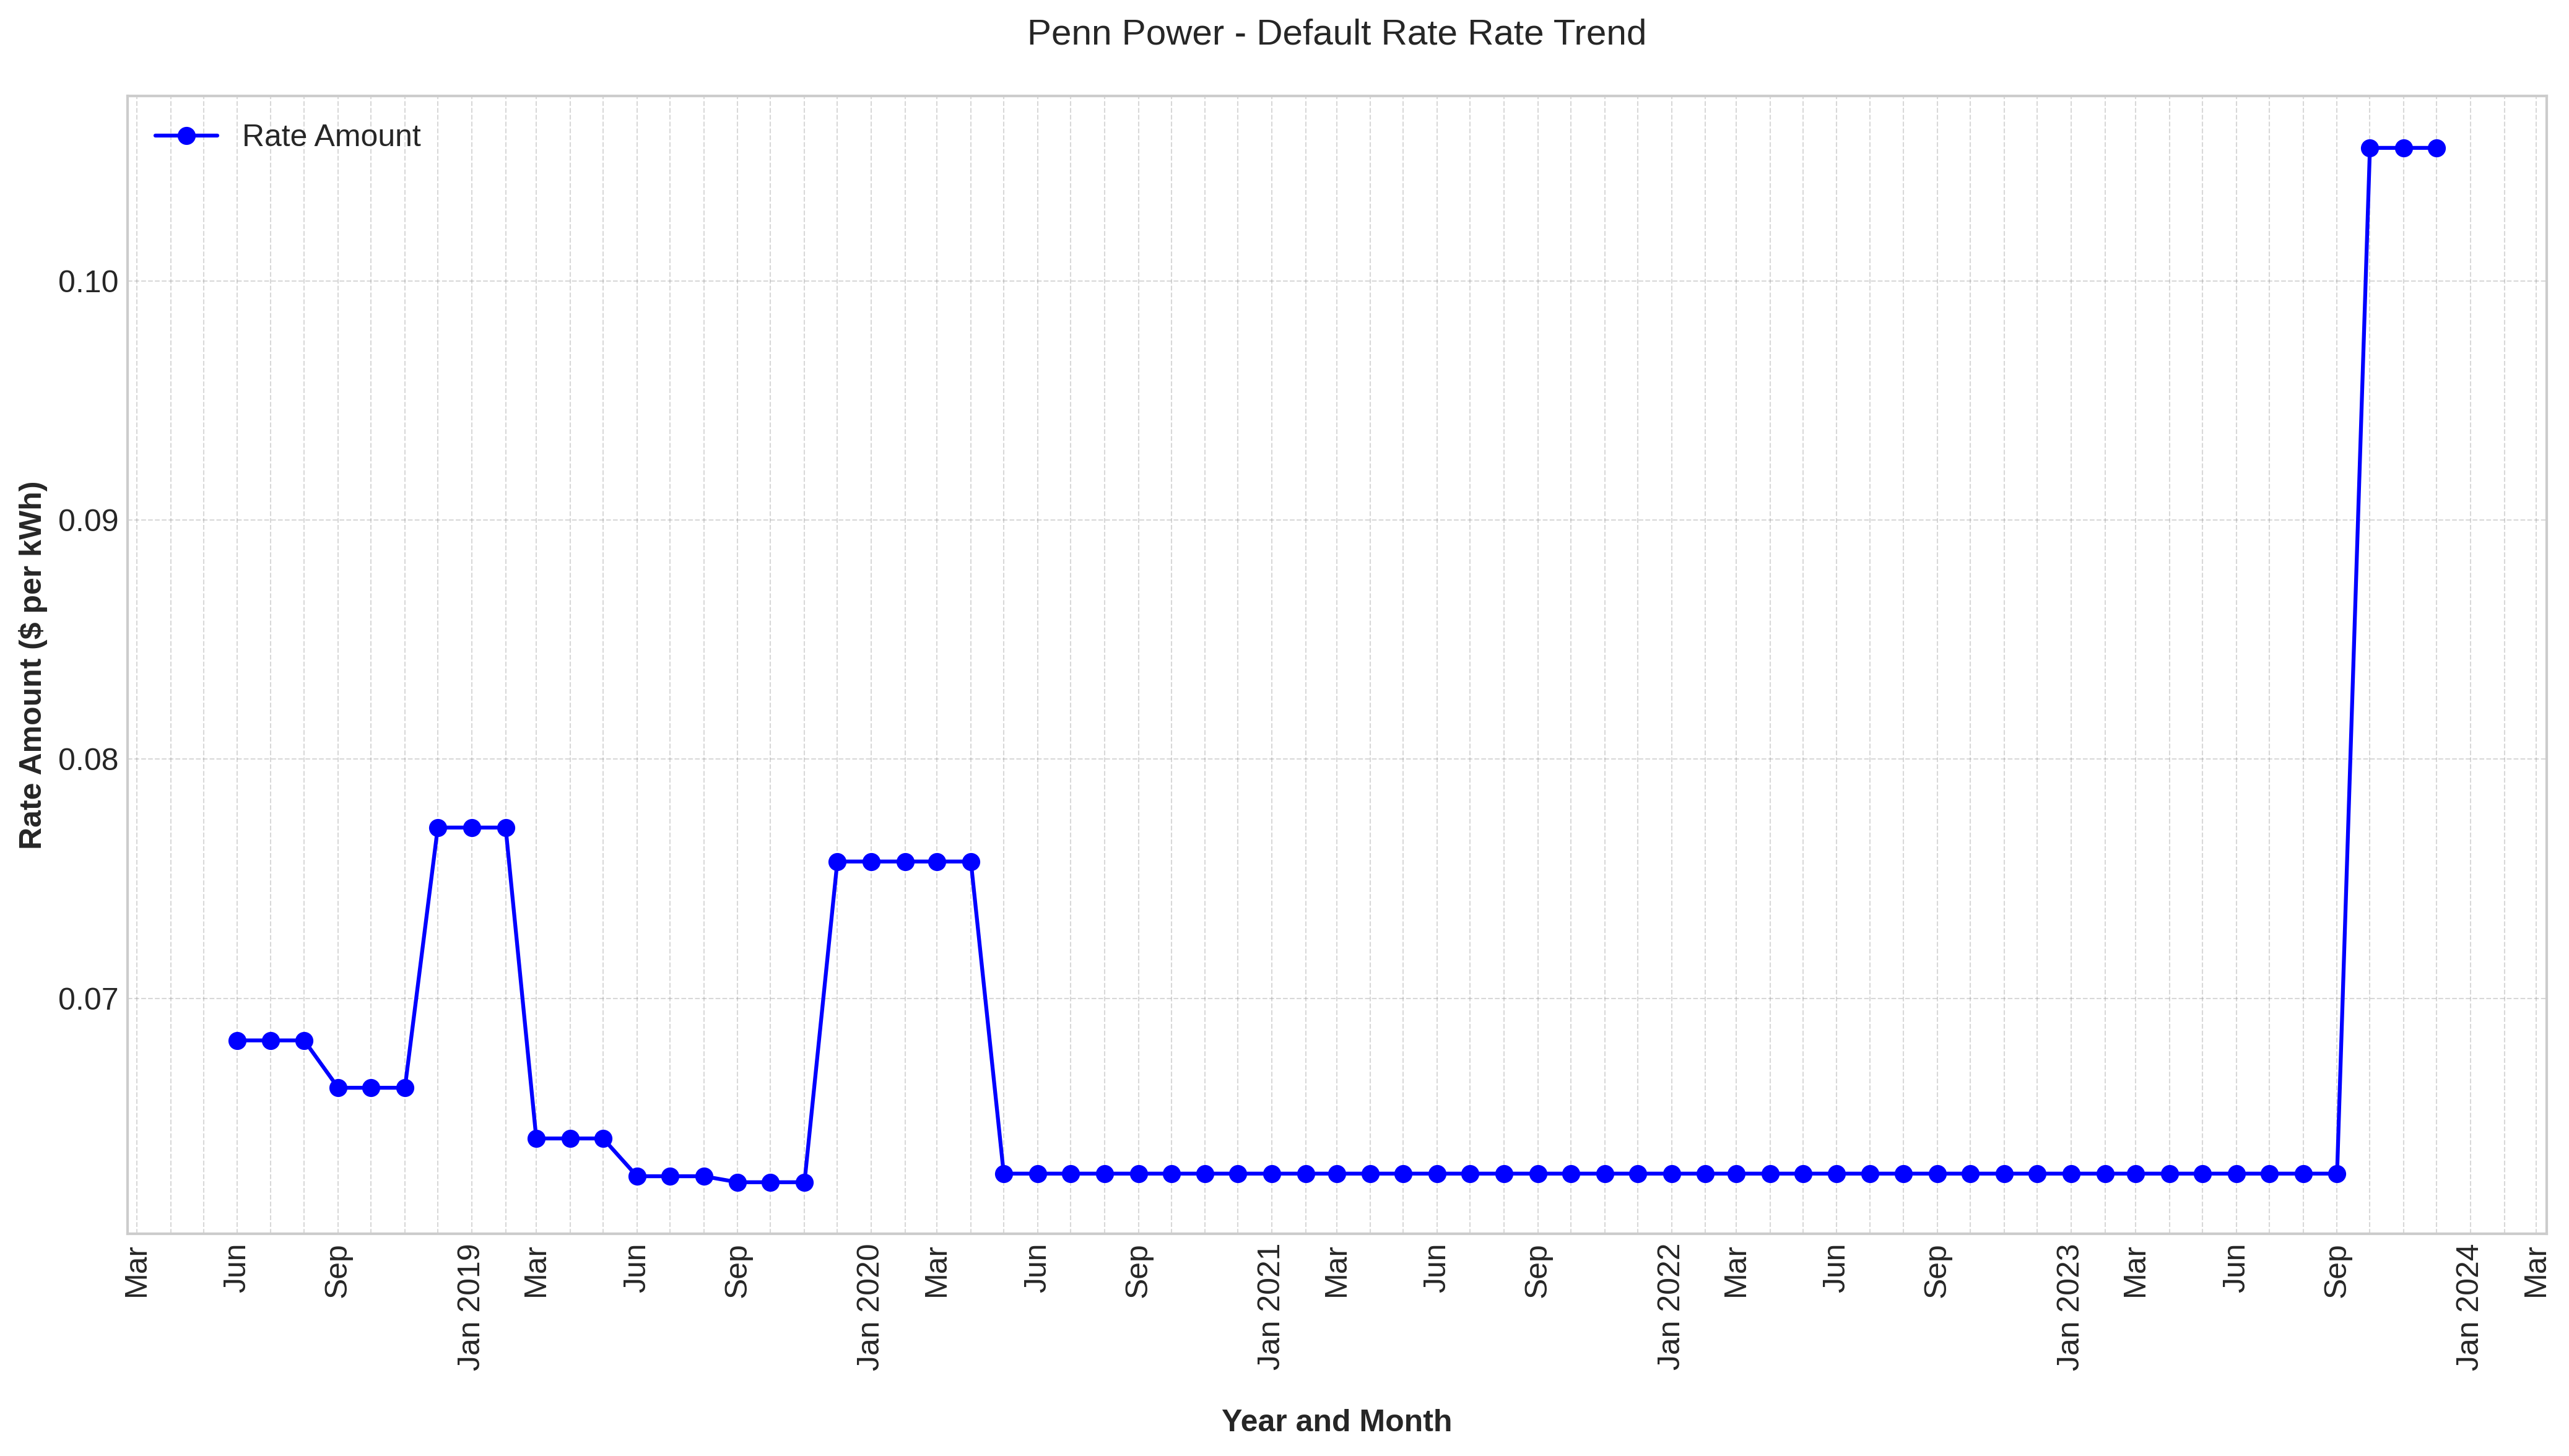

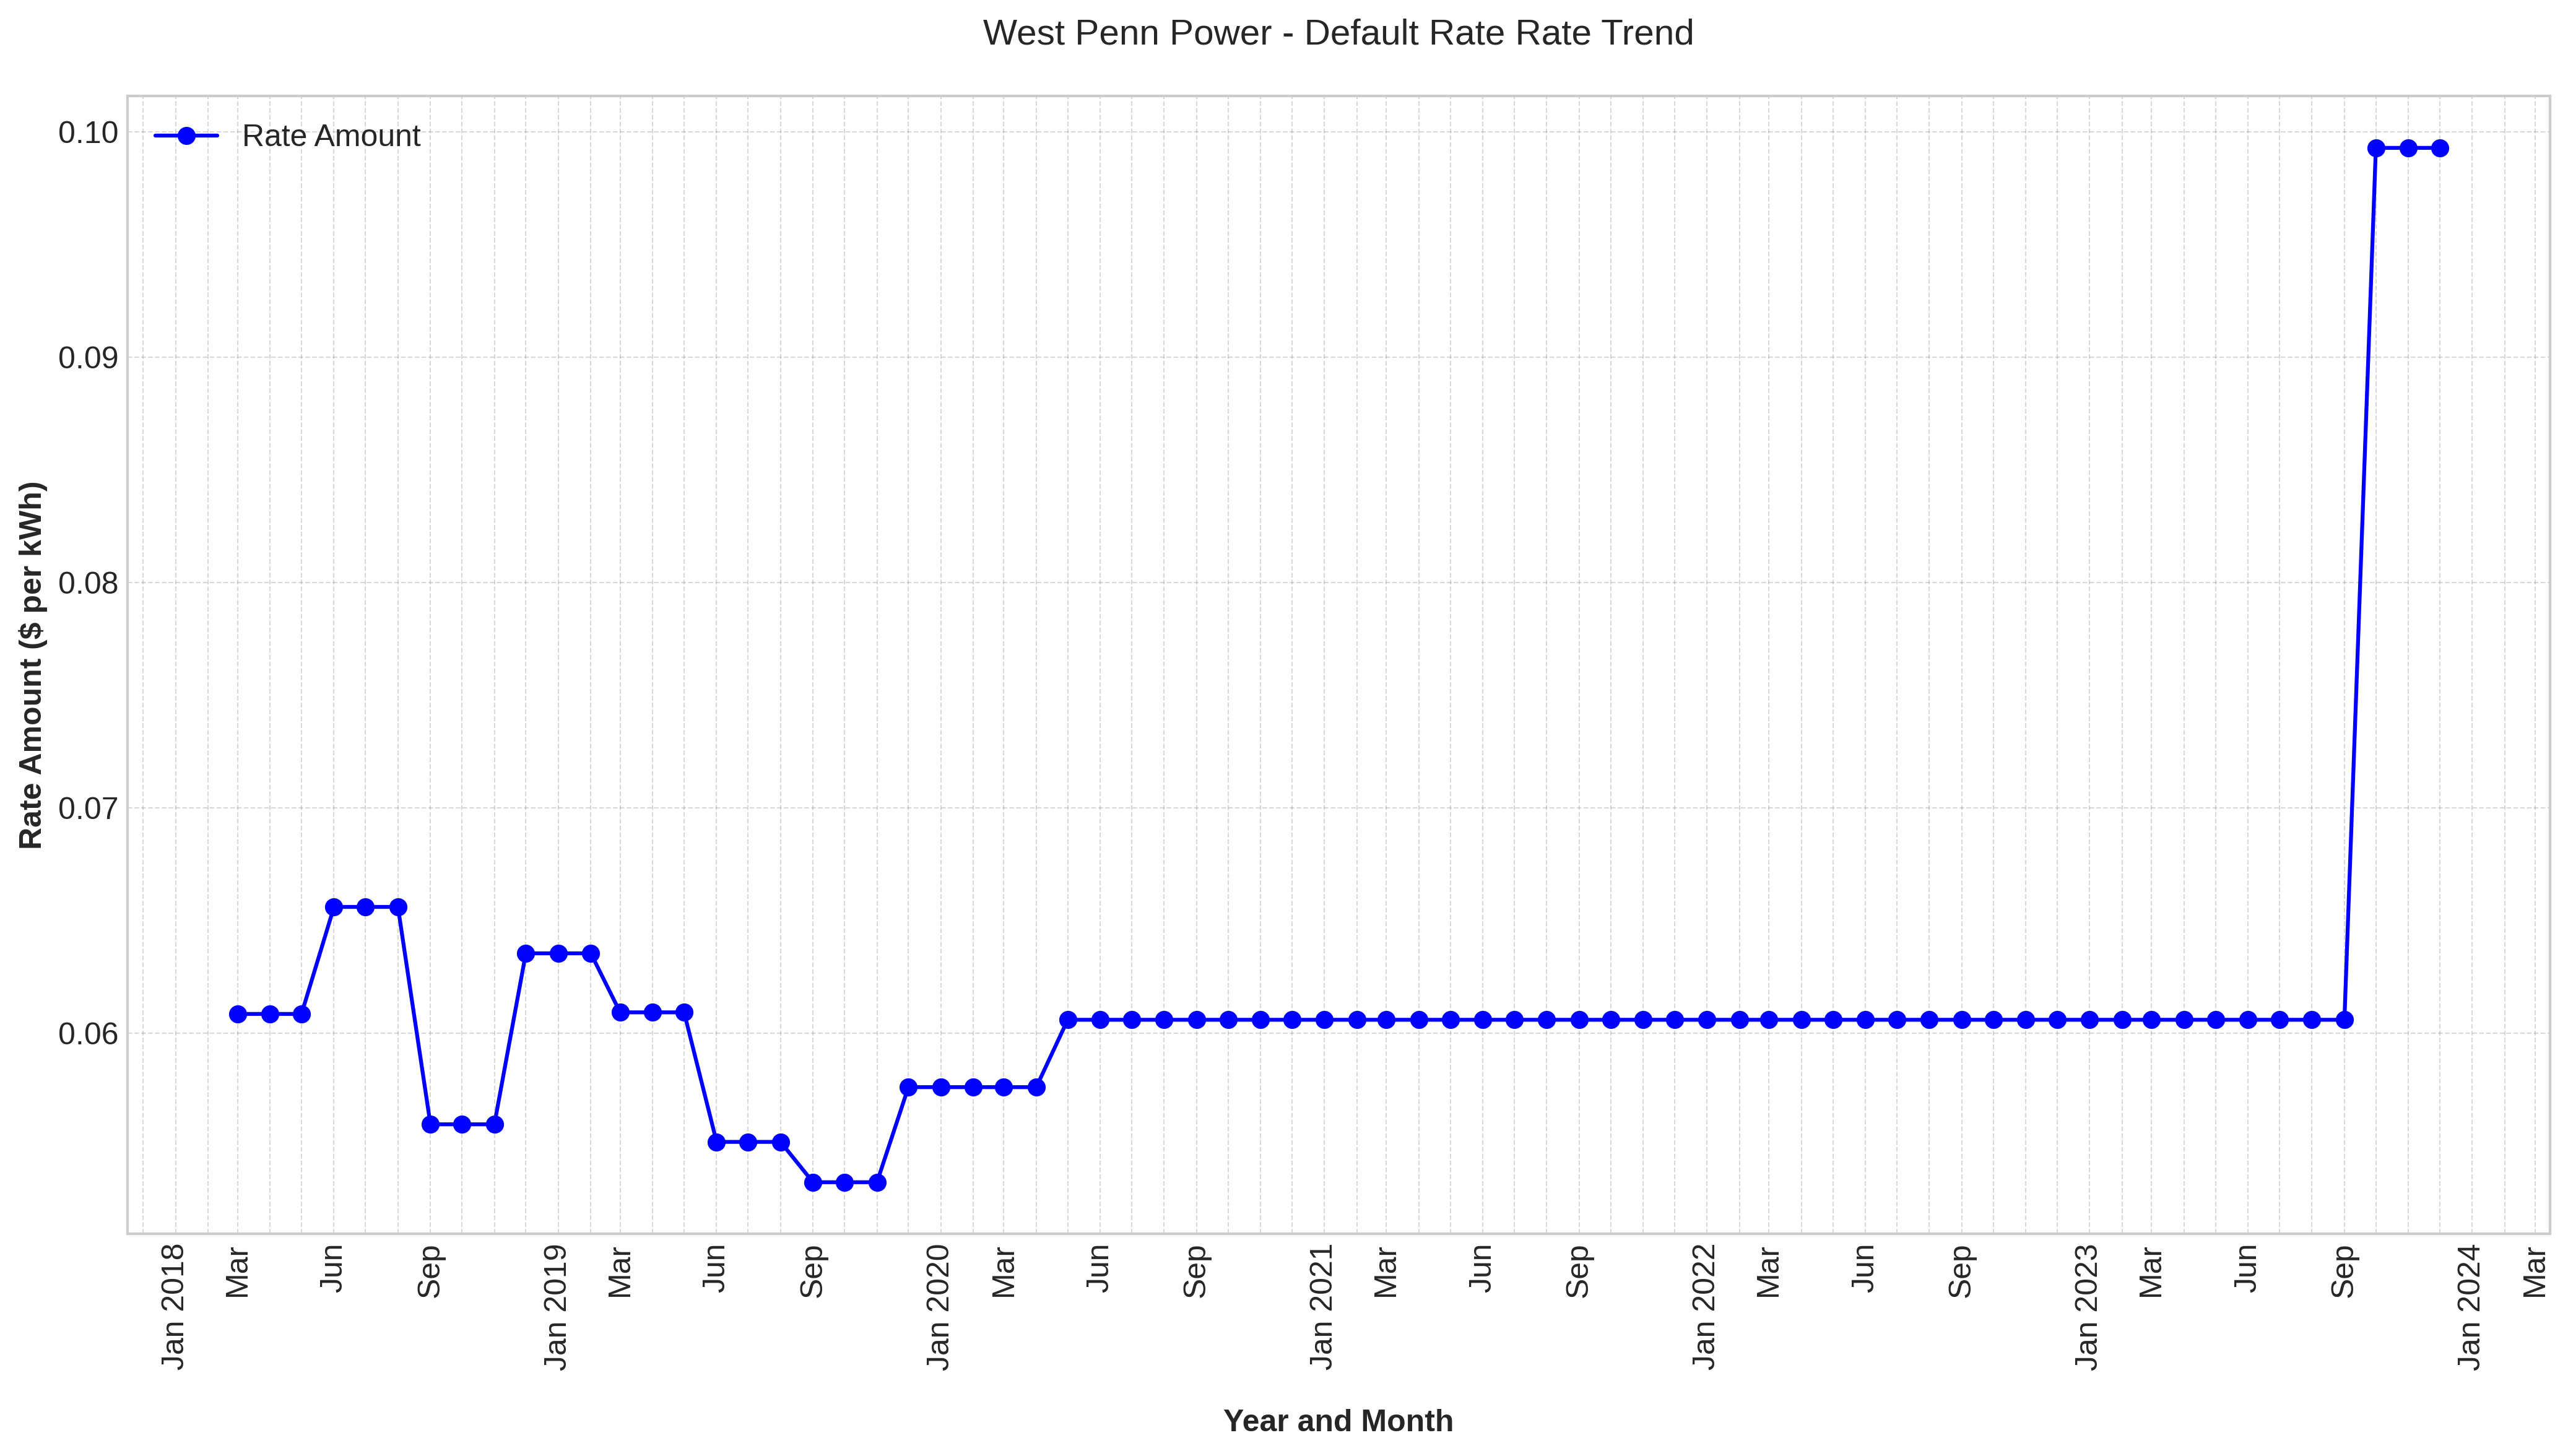

In [ ]:
# plot for each utility
for (utility_name, utility_rate_type), group_indices in df_combined.groupby(['utility_name', 'utility_rate_type']).groups.items():
    utility_data = df_combined.loc[group_indices].copy()
    plot_utility_monthly_rate_trend(utility_data, utility_name, utility_rate_type)

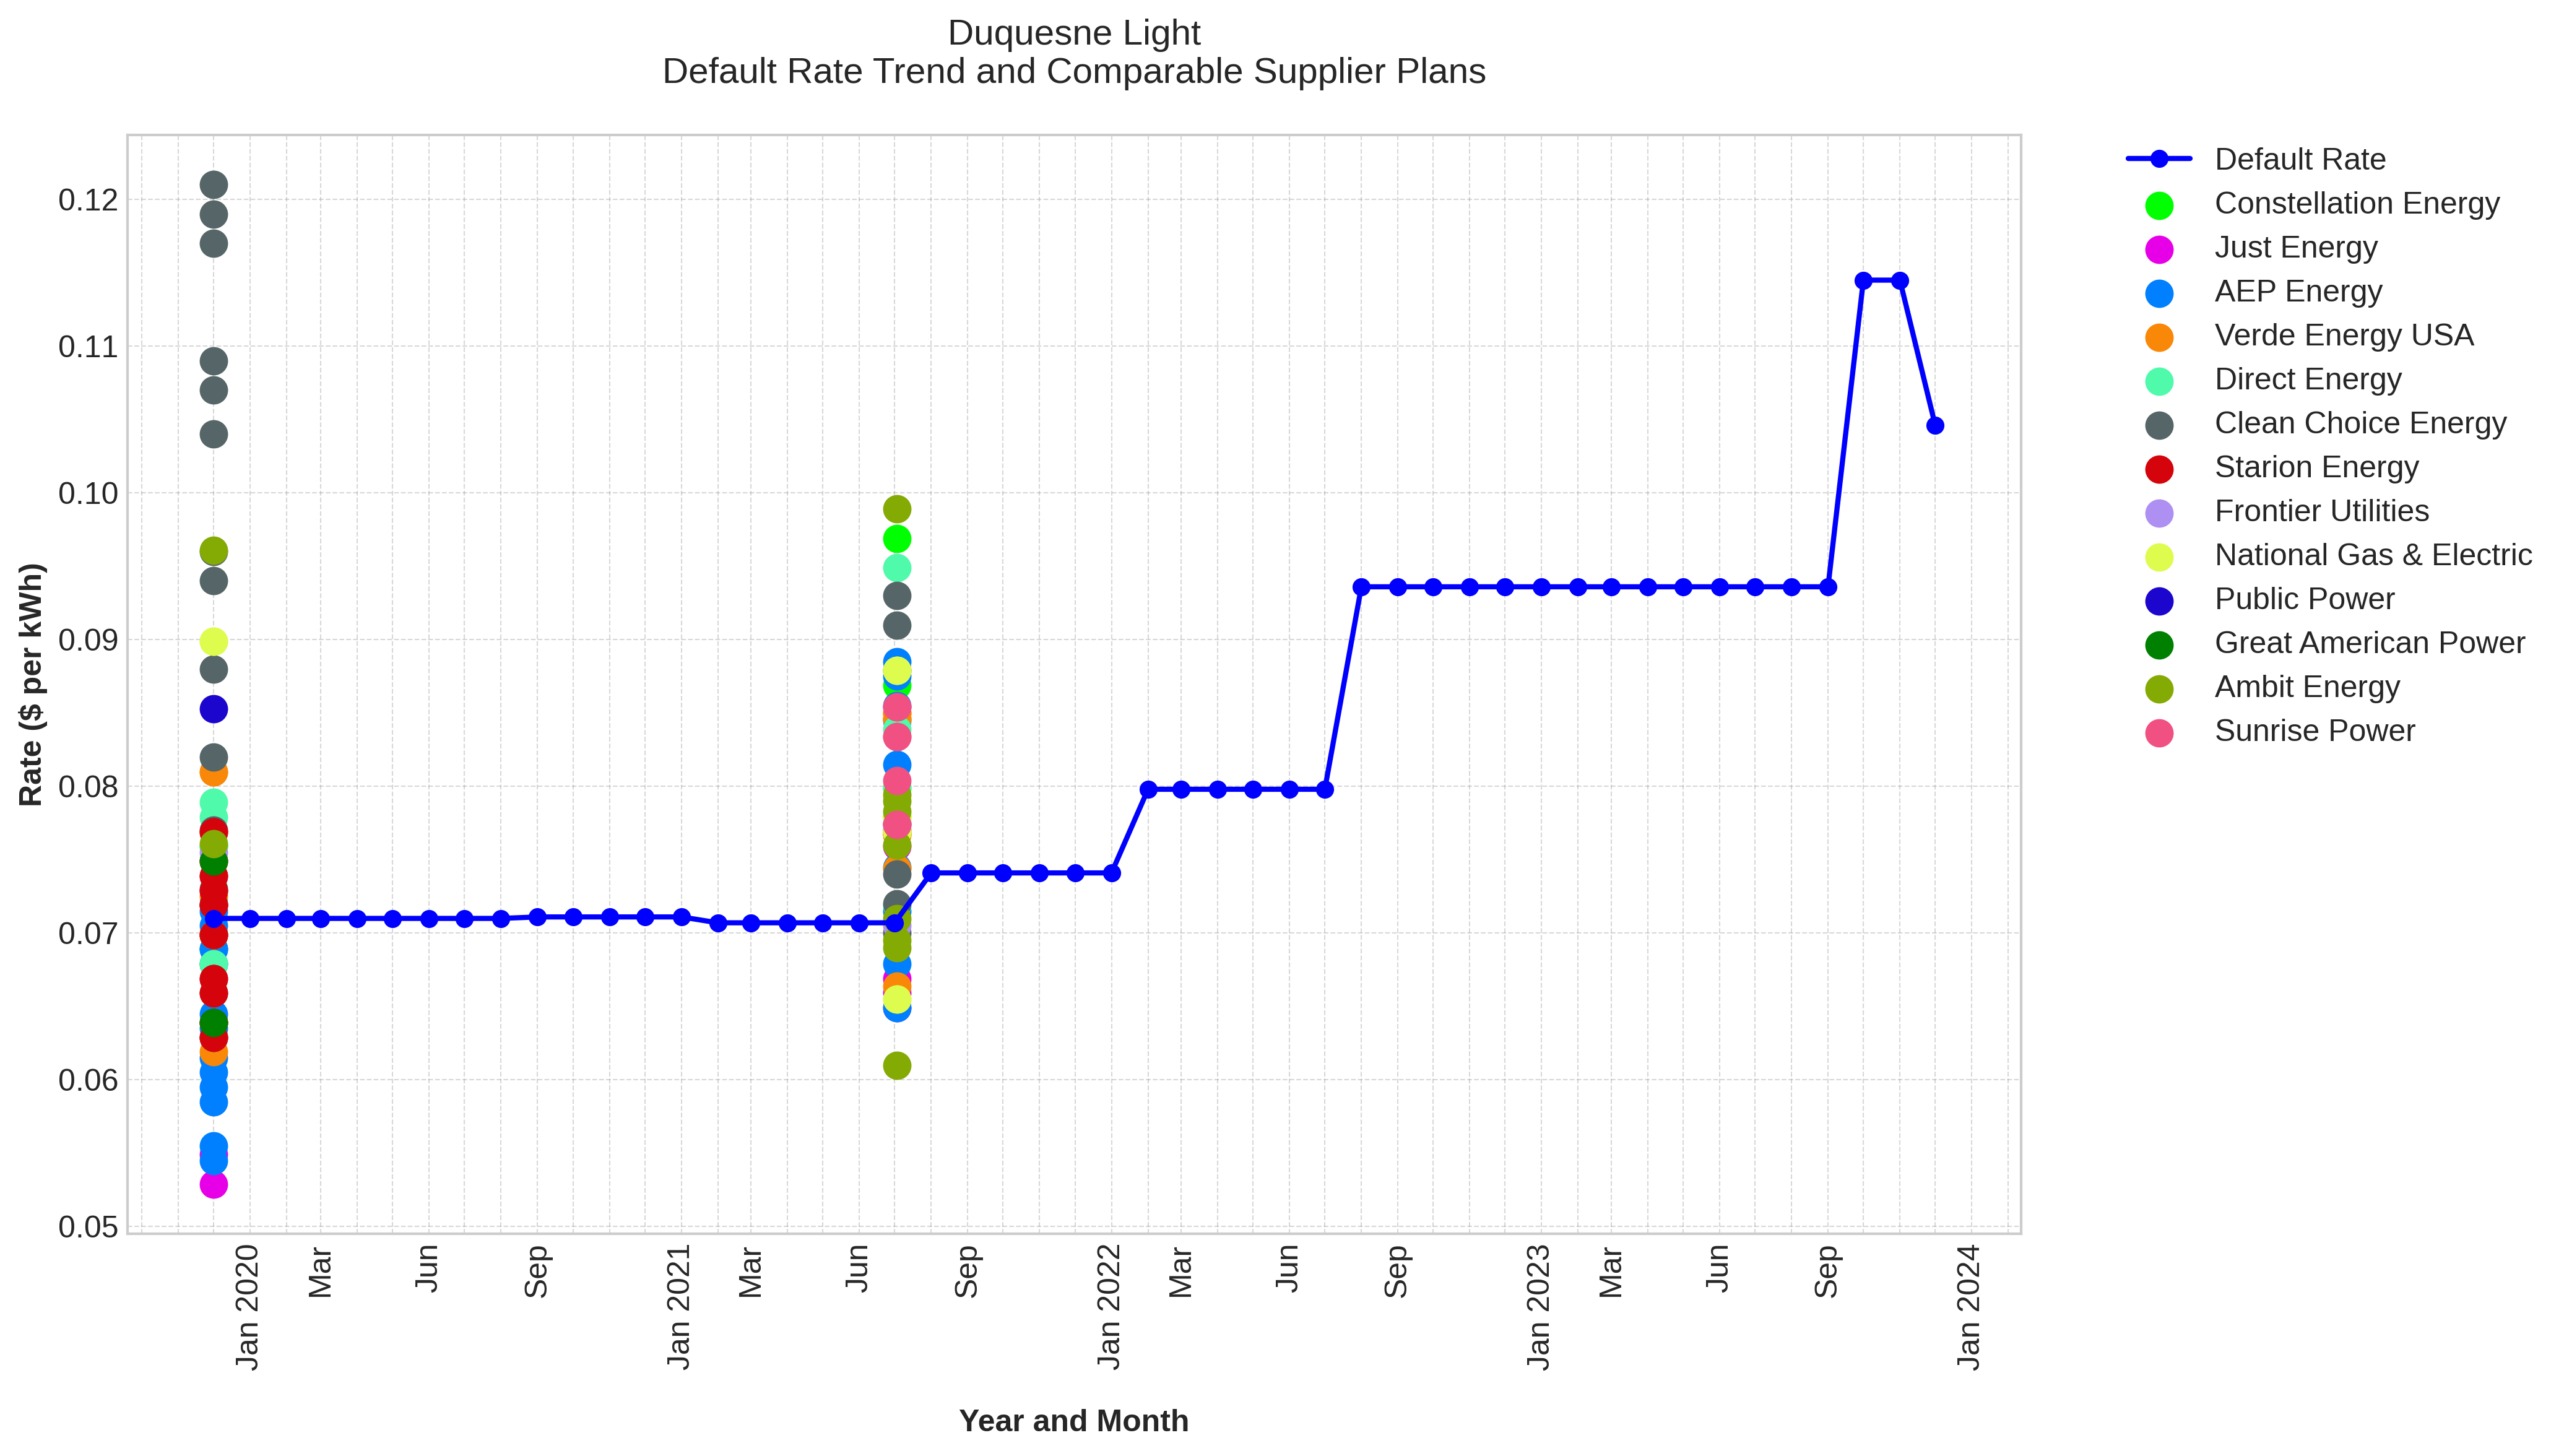

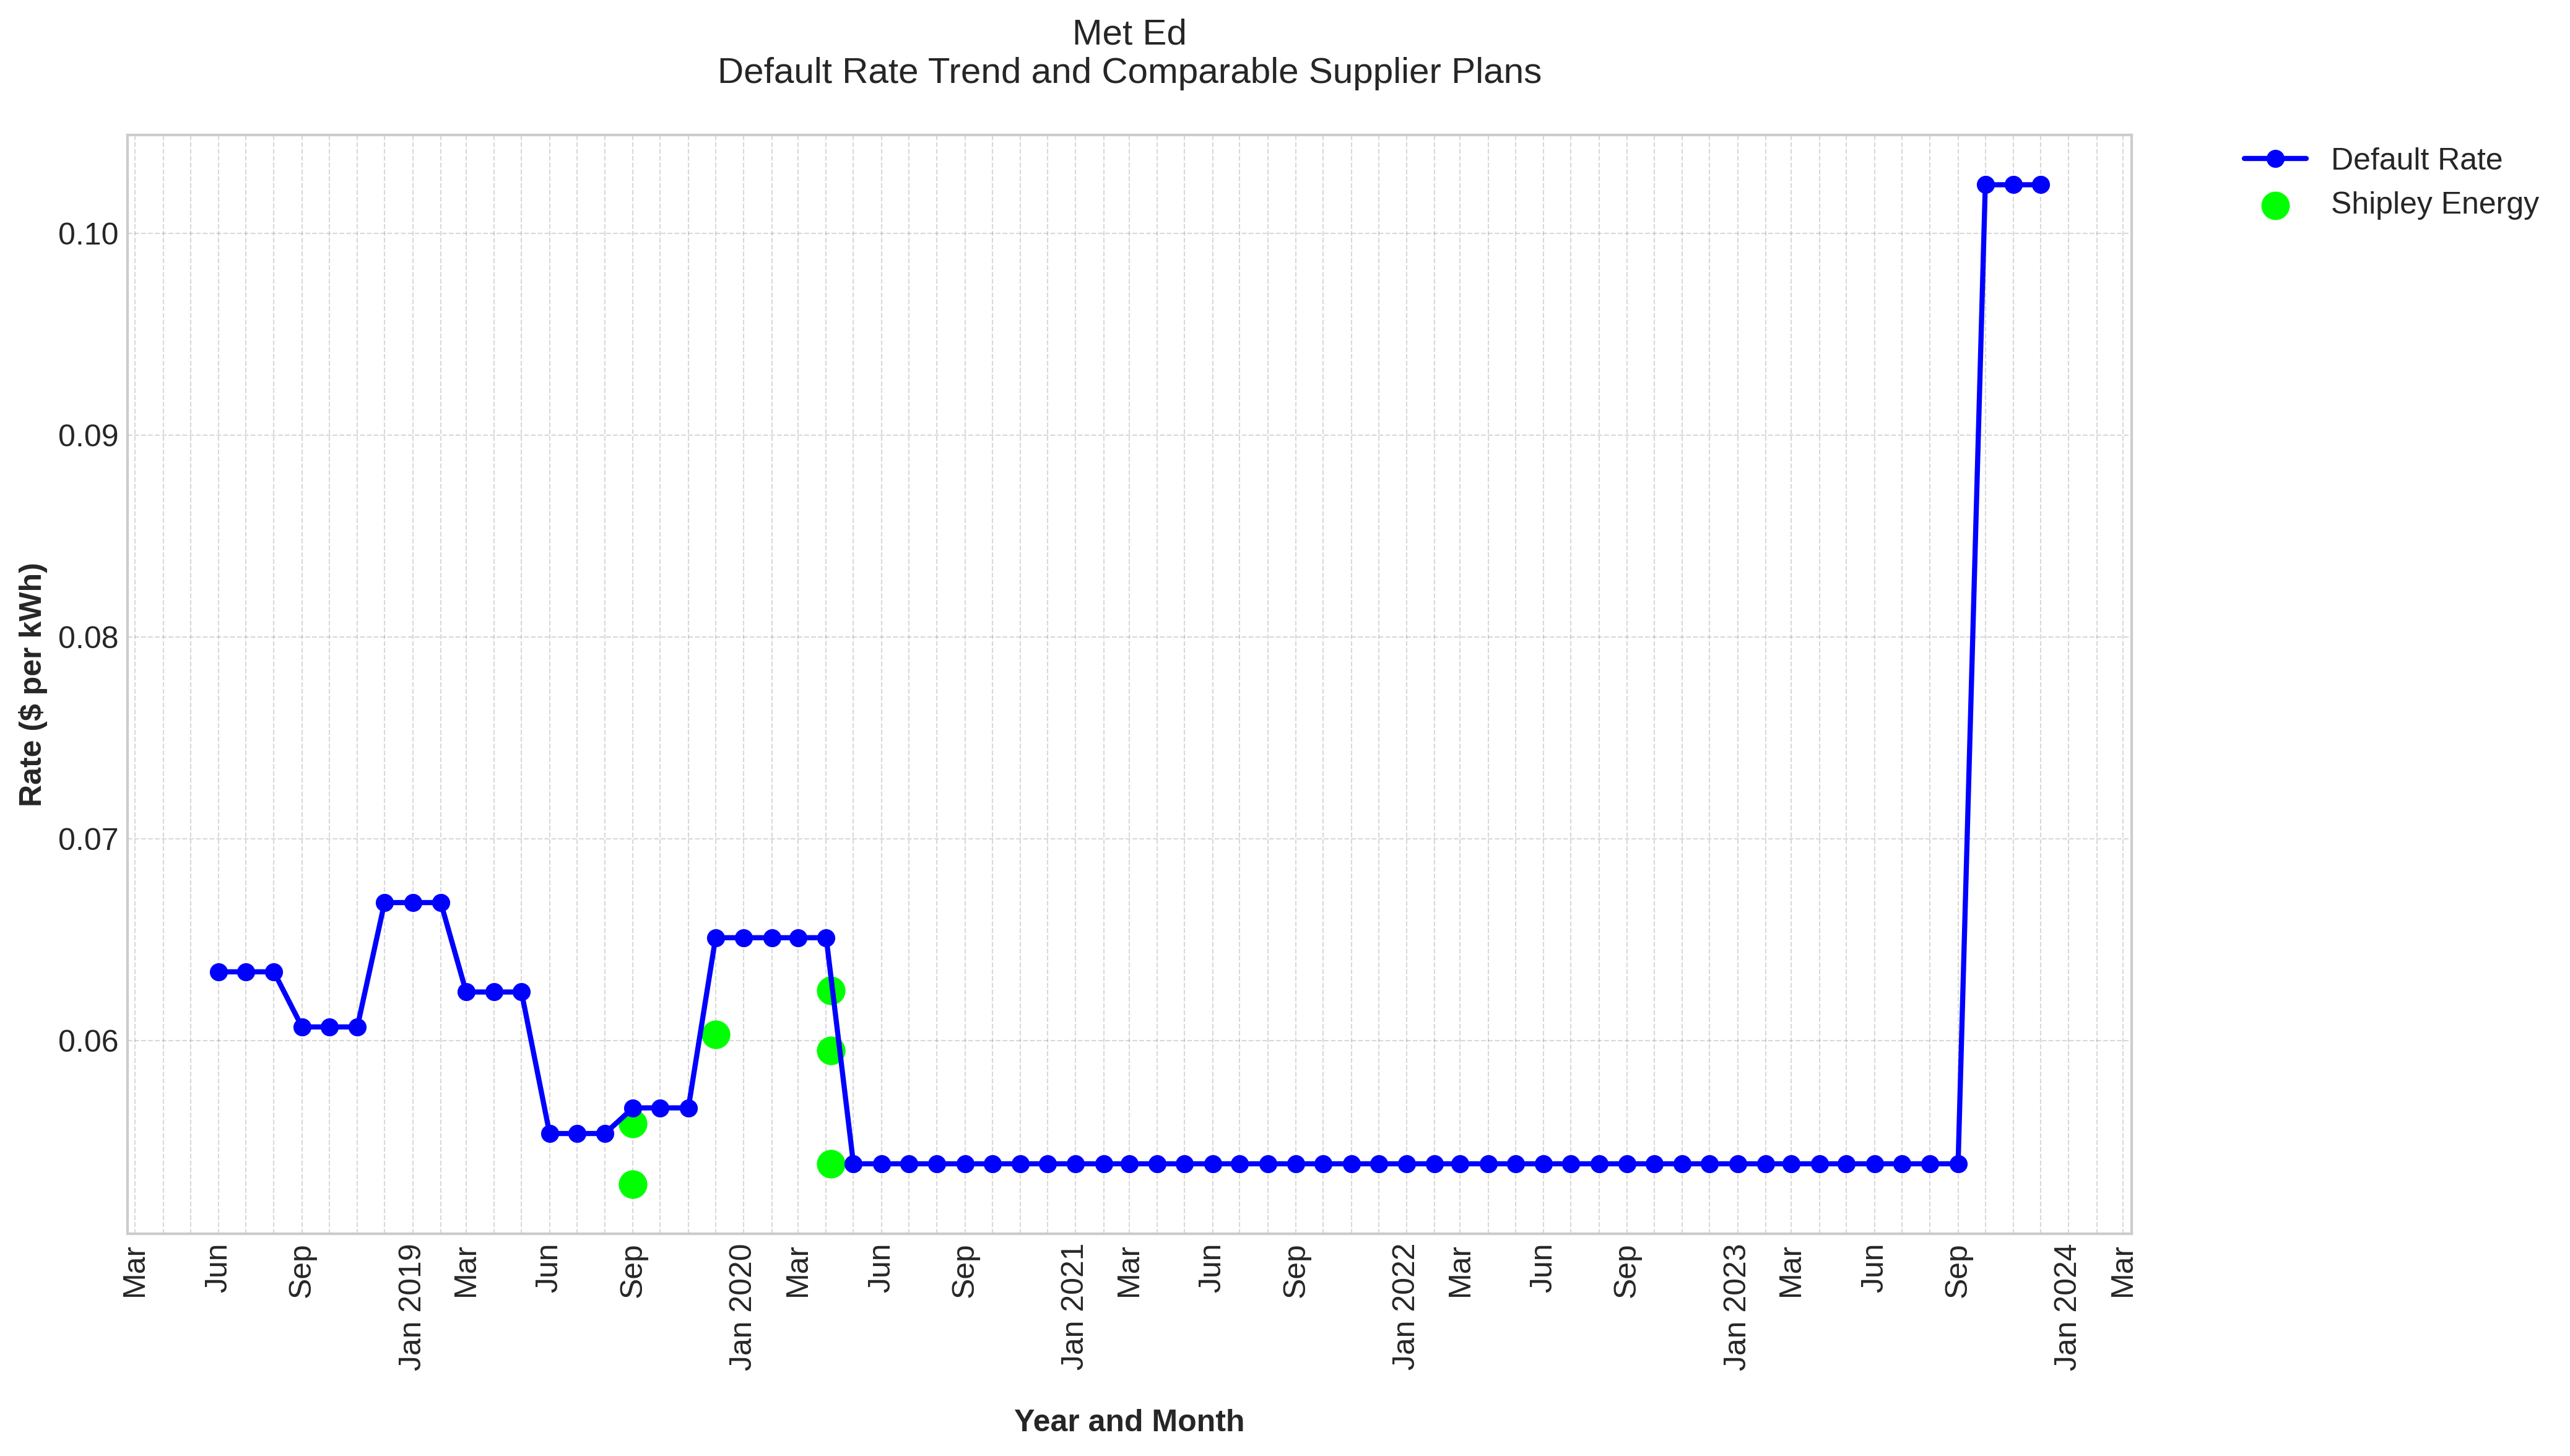

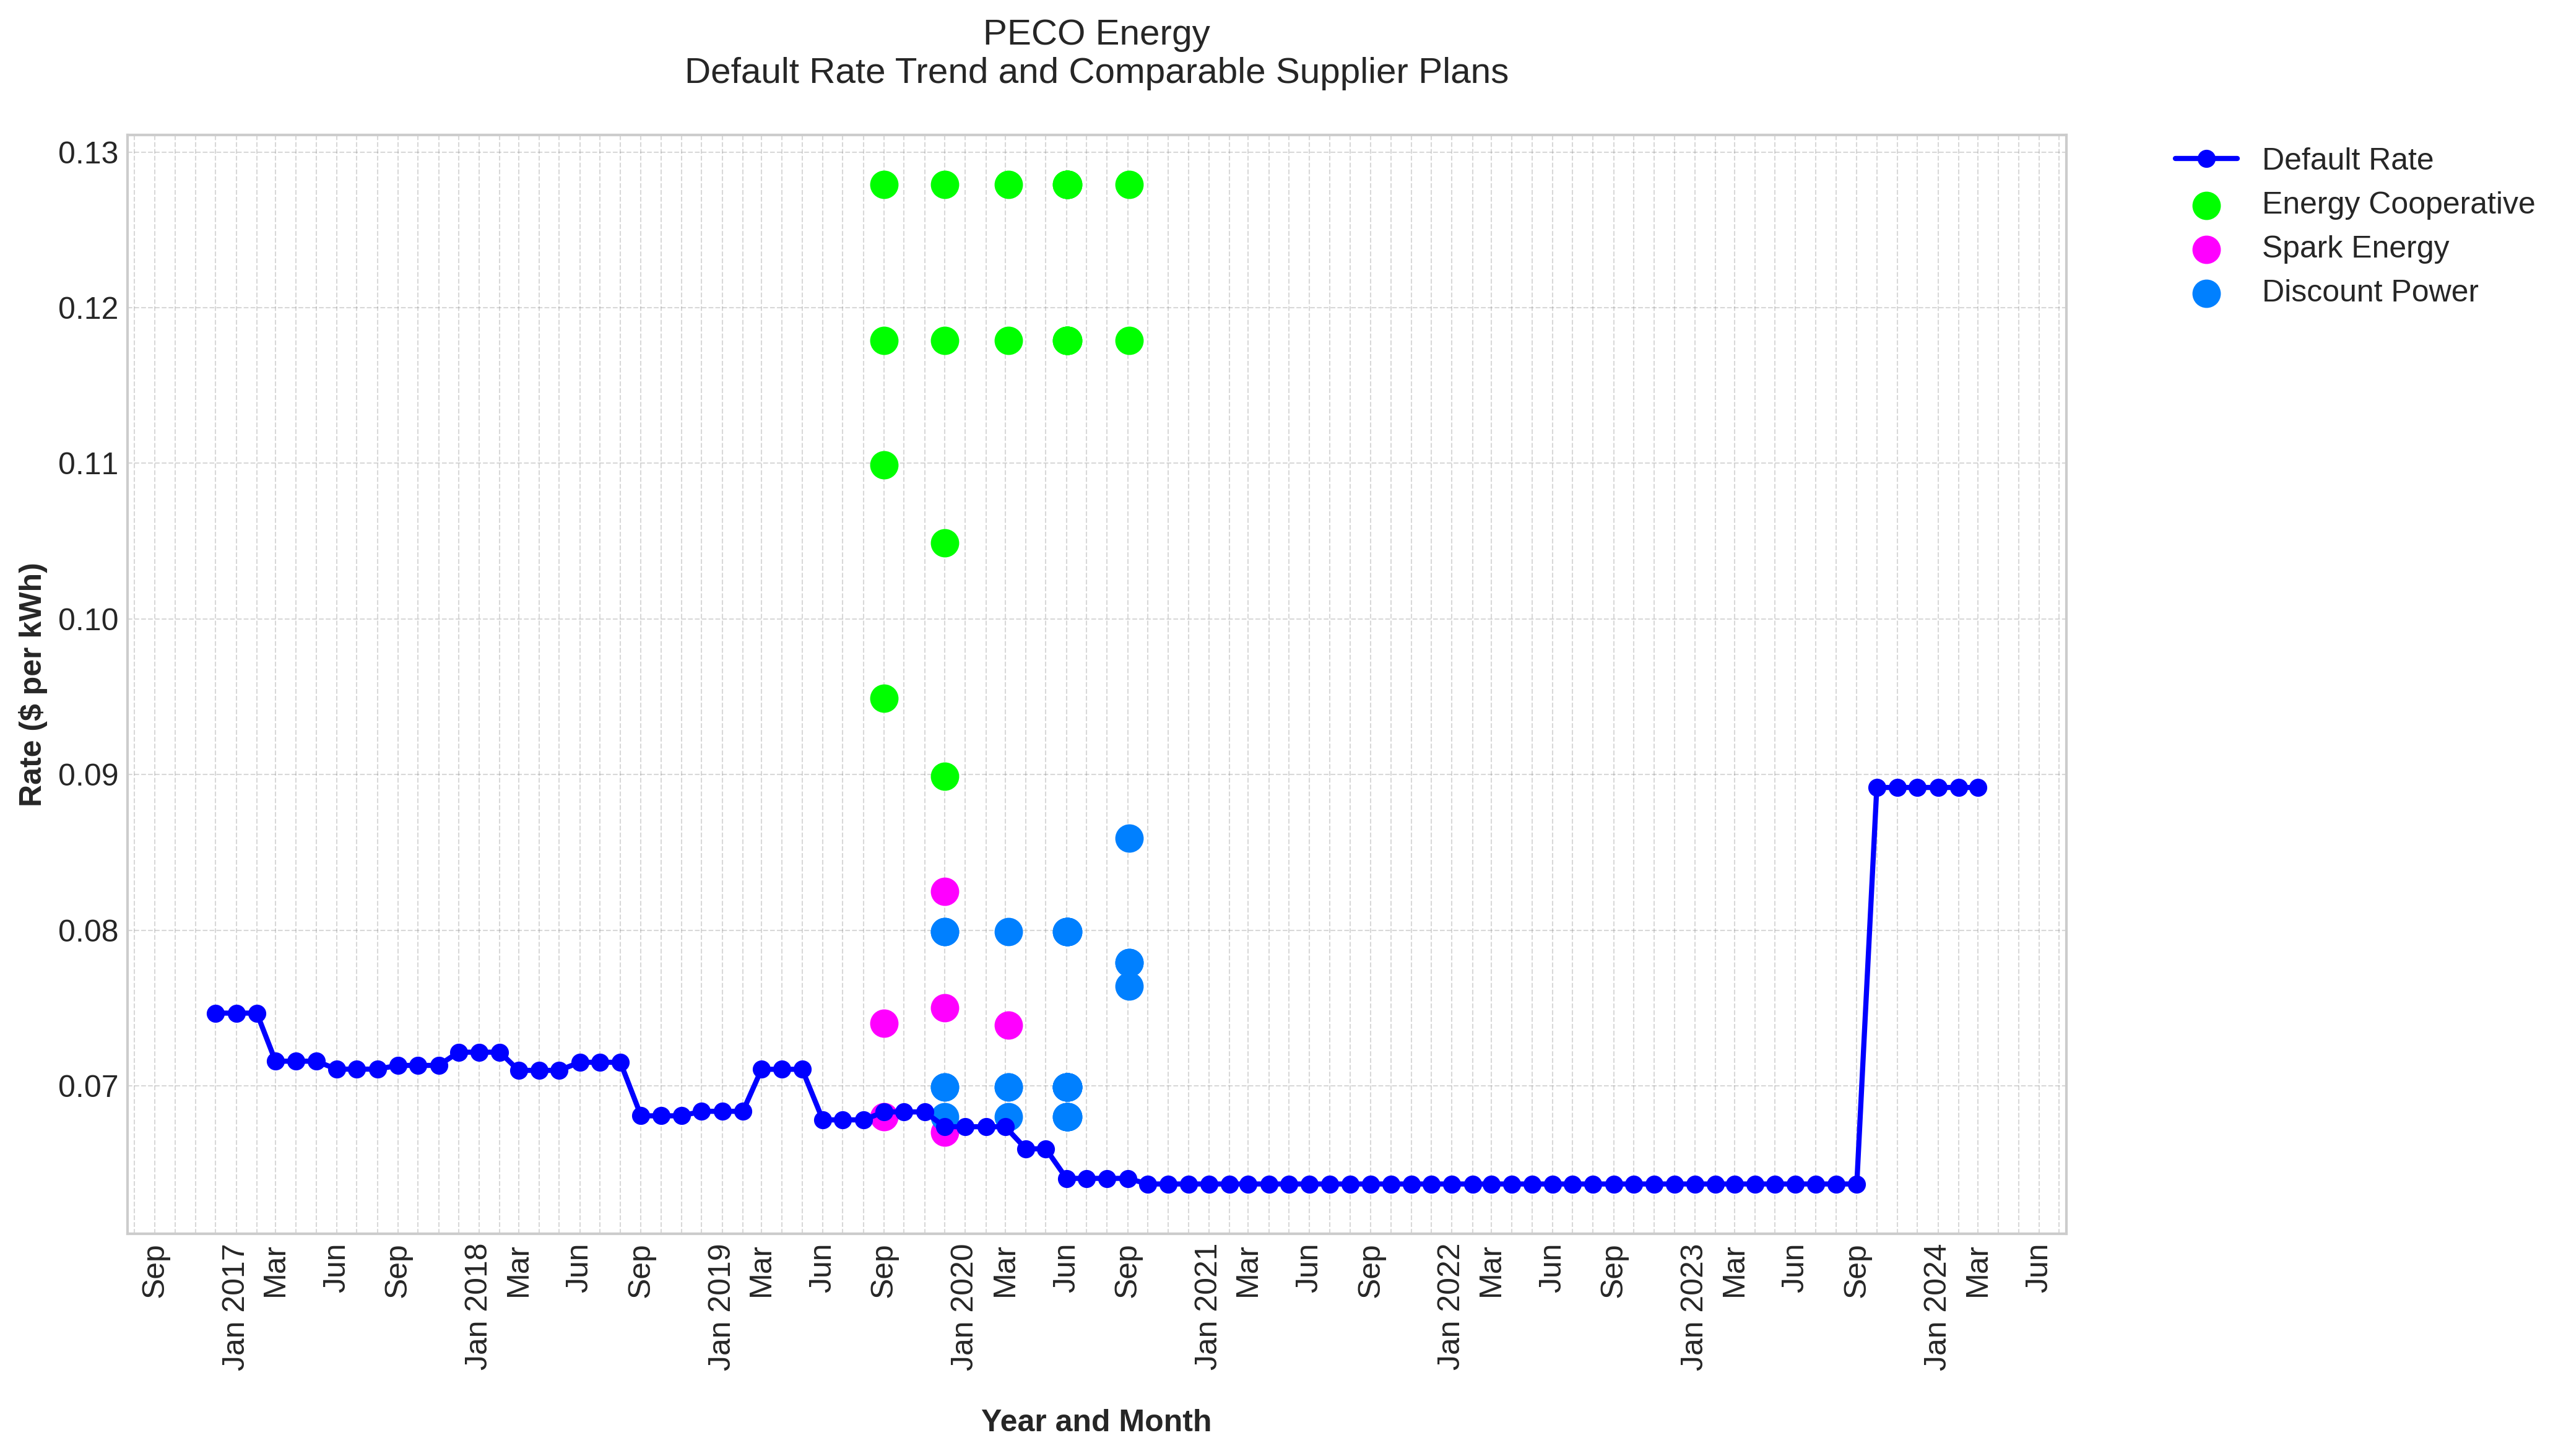

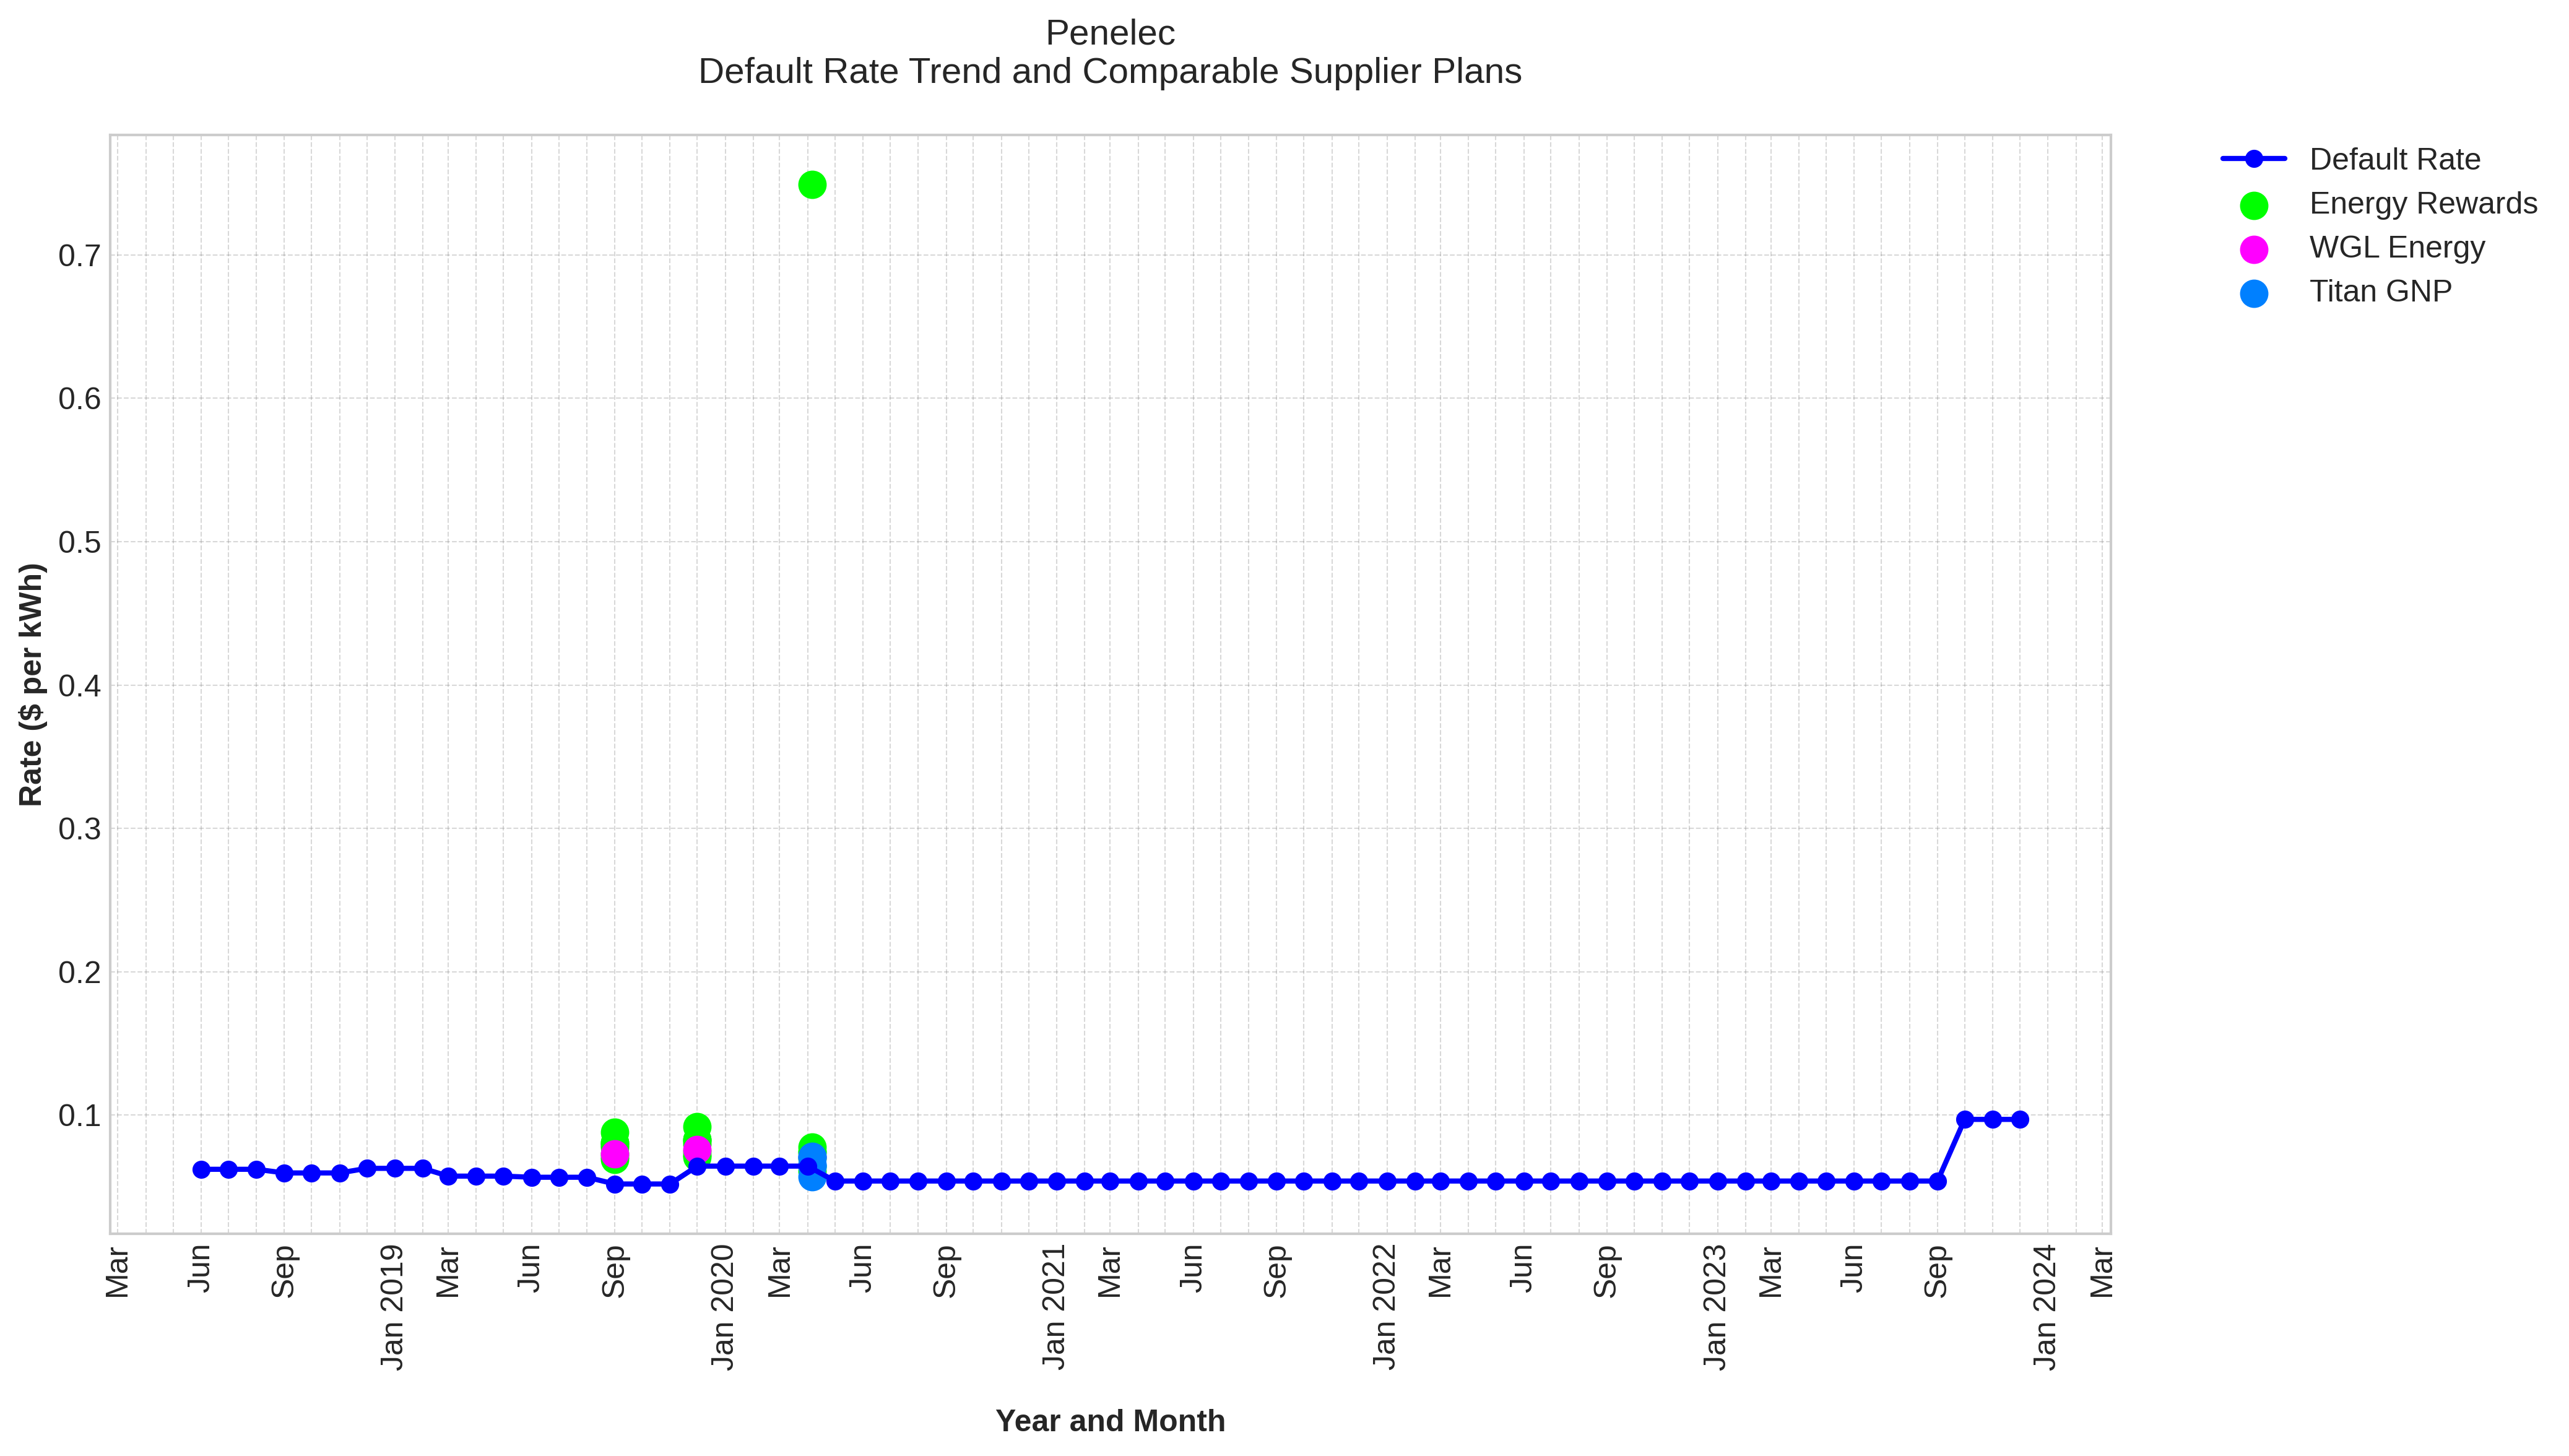

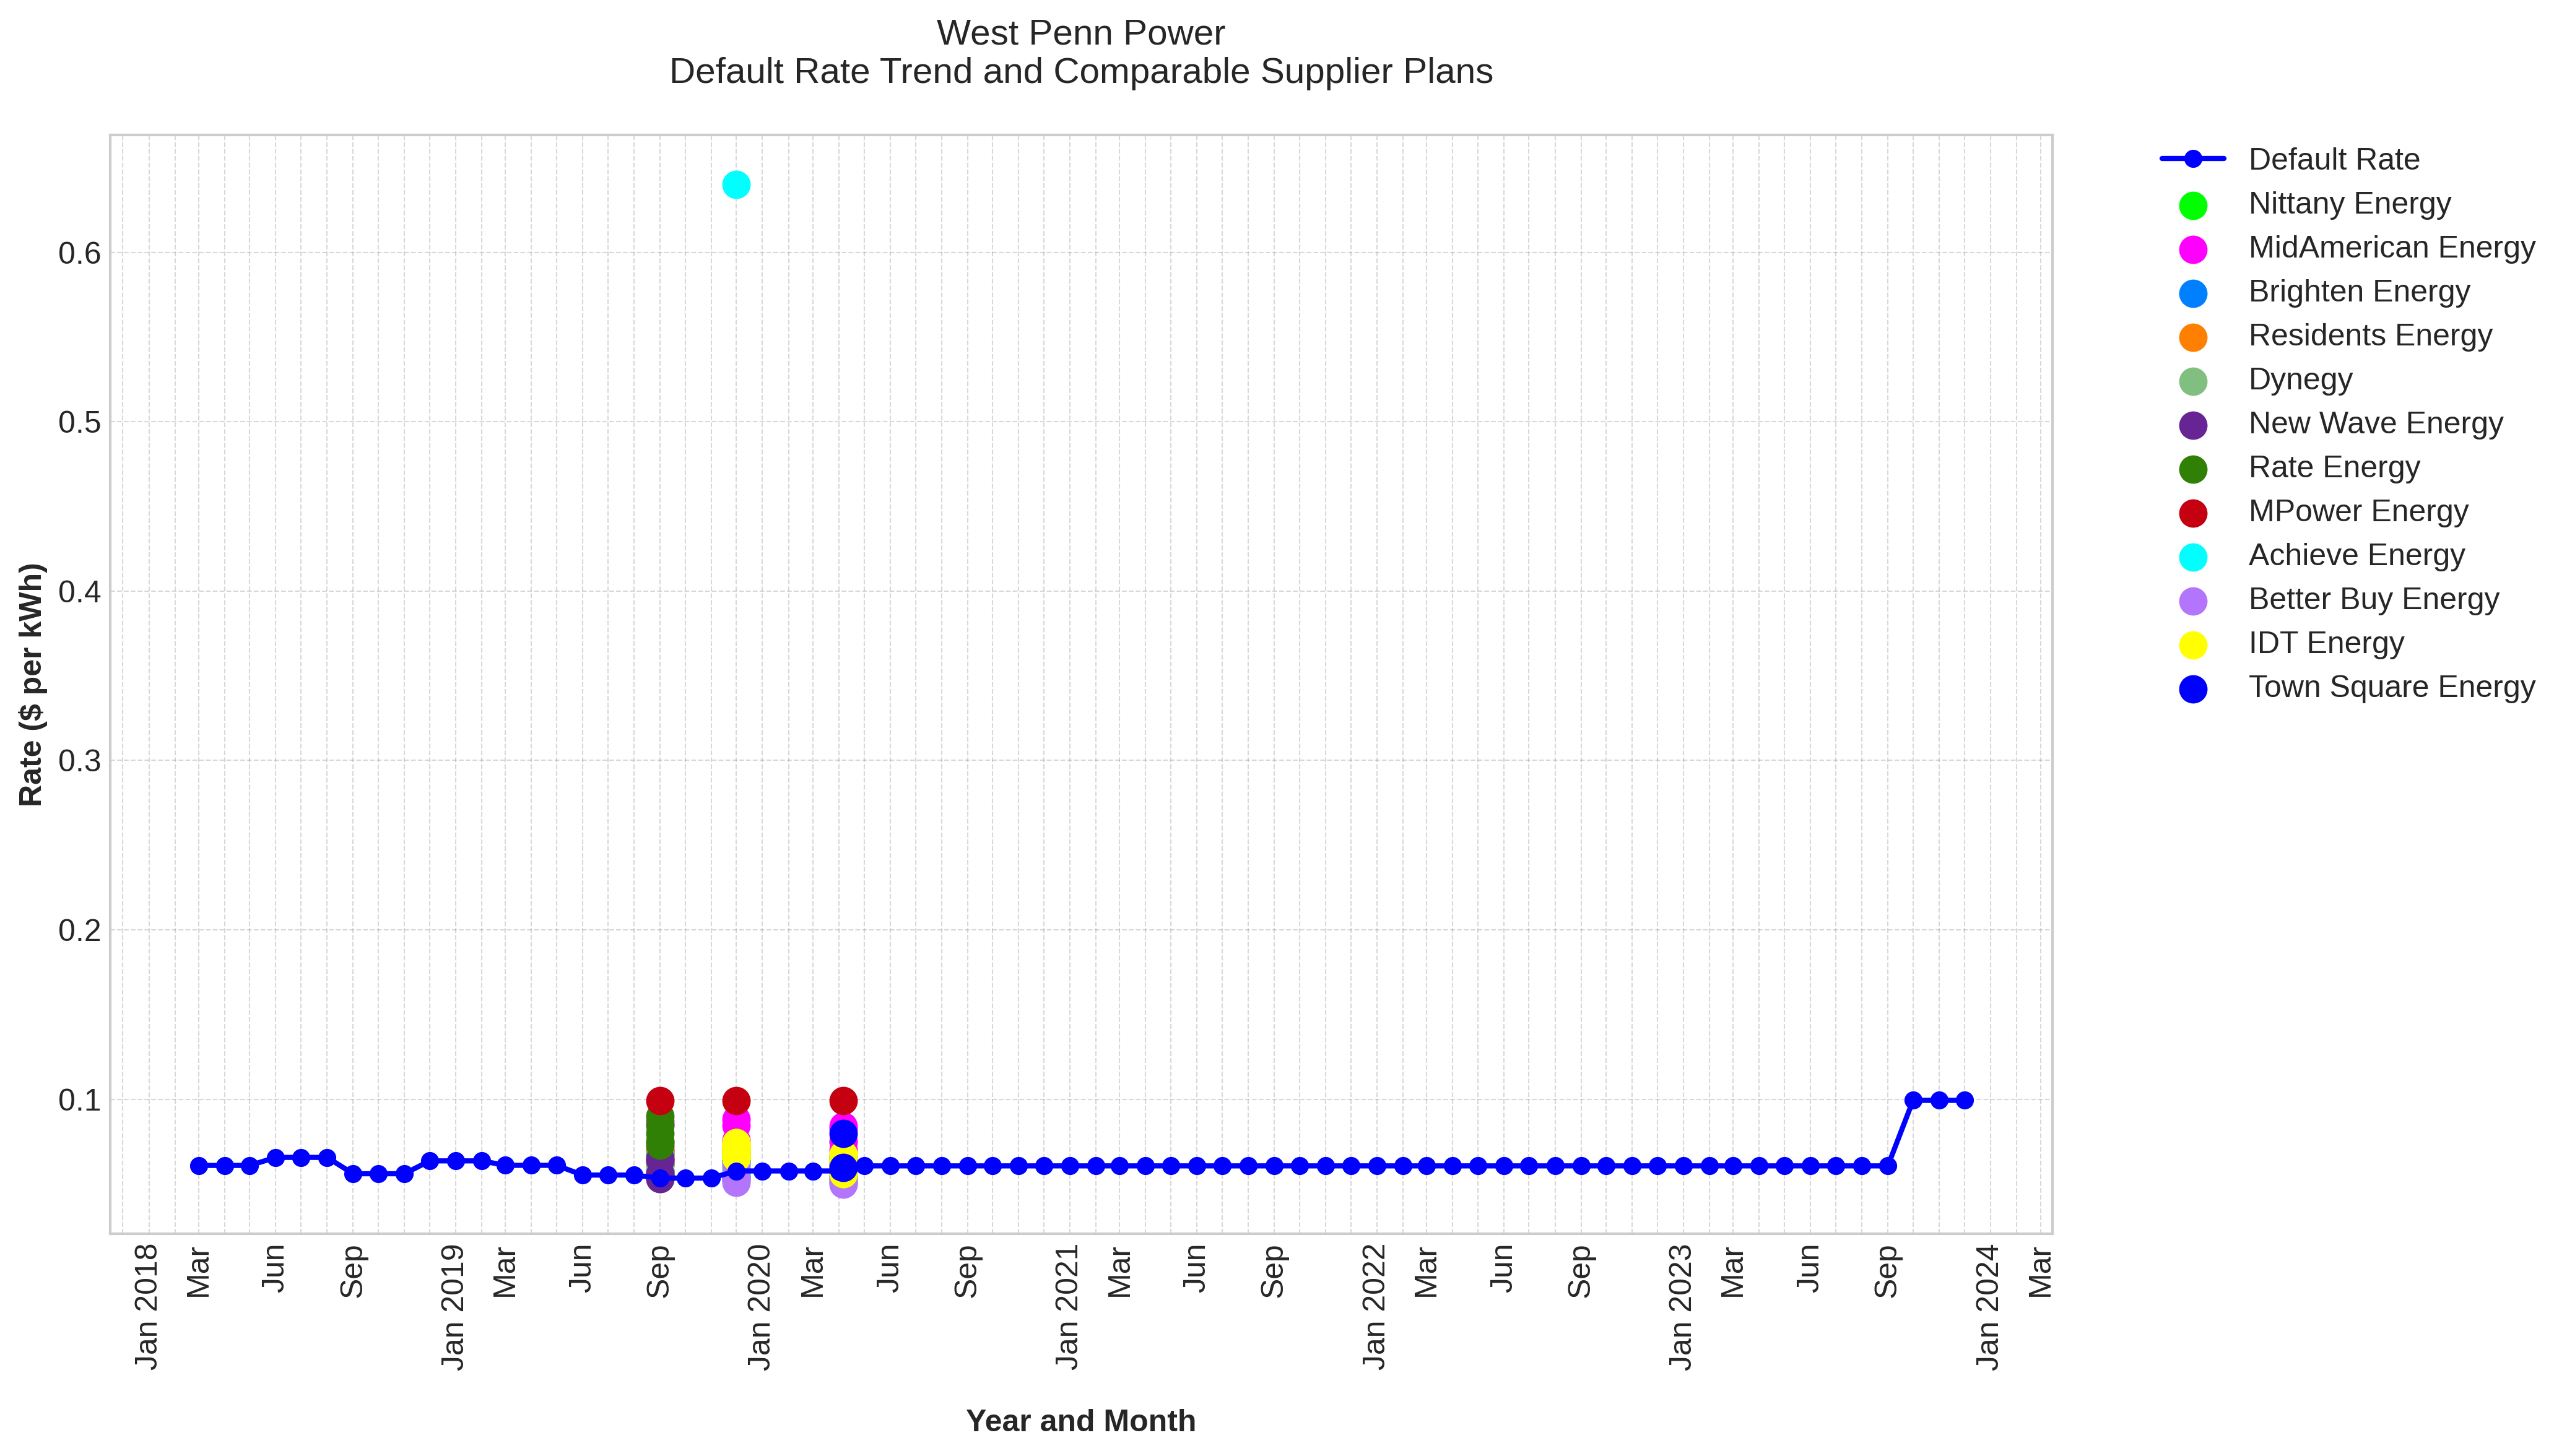

In [ ]:
# Loop through each utility in df_combined
for utility_name, group in df_combined.groupby('utility_name'):
    # get utility data (default rate)
    utility_data = group.copy()

    # get matching supplier plans for this utility from filtered_suppliers
    utility_suppliers = filtered_suppliers[filtered_suppliers['utility_name'] == utility_name].copy()

    # if we have both utility data and supplier plans, create plot
    if not utility_suppliers.empty:
        # resample utility data to monthly
        utility_data = utility_data.set_index('created_at')
        utility_monthly = utility_data.resample('MS').first().reset_index()
        utility_monthly = utility_monthly.sort_values(by='created_at')

        # create plot
        fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

        # plot default rate
        ax.plot(
            utility_monthly['created_at'],
            utility_monthly['utility_rate_amount'],
            label='Default Rate',
            marker='o',
            linestyle='-',
            color='blue',
            linewidth=2
        )

        # generate colors for suppliers
        suppliers = utility_suppliers['supplier_name'].unique()
        colors = distinctipy.get_colors(len(suppliers))
        color_dict = dict(zip(suppliers, colors))

        # plot supplier plans
        for supplier in suppliers:
            supplier_data = utility_suppliers[utility_suppliers['supplier_name'] == supplier]
            ax.scatter(
                supplier_data['created_at'],
                supplier_data['plan_rate_amount'],
                color=color_dict[supplier],
                marker='o',
                label=supplier,
                s=100  # marker size
            )

        # format x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

        plt.setp(ax.get_xticklabels(which='both'), rotation=90)

        # labels and title
        ax.set_xlabel('Year and Month', fontsize=12, fontweight='bold', labelpad=15)
        ax.set_ylabel('Rate ($ per kWh)', fontsize=12, fontweight='bold')
        ax.set_title(f'{utility_name}\nDefault Rate Trend and Comparable Supplier Plans',
                    fontsize=14, pad=20)

        # grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

        # legend outside plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.tight_layout()

        # save plot
        plt.savefig(os.path.join(ANALYSIS_DIR, f"{utility_name.replace(' ', '_')}_comparison.png"),
                    bbox_inches='tight',
                    dpi=300)

        plt.show()

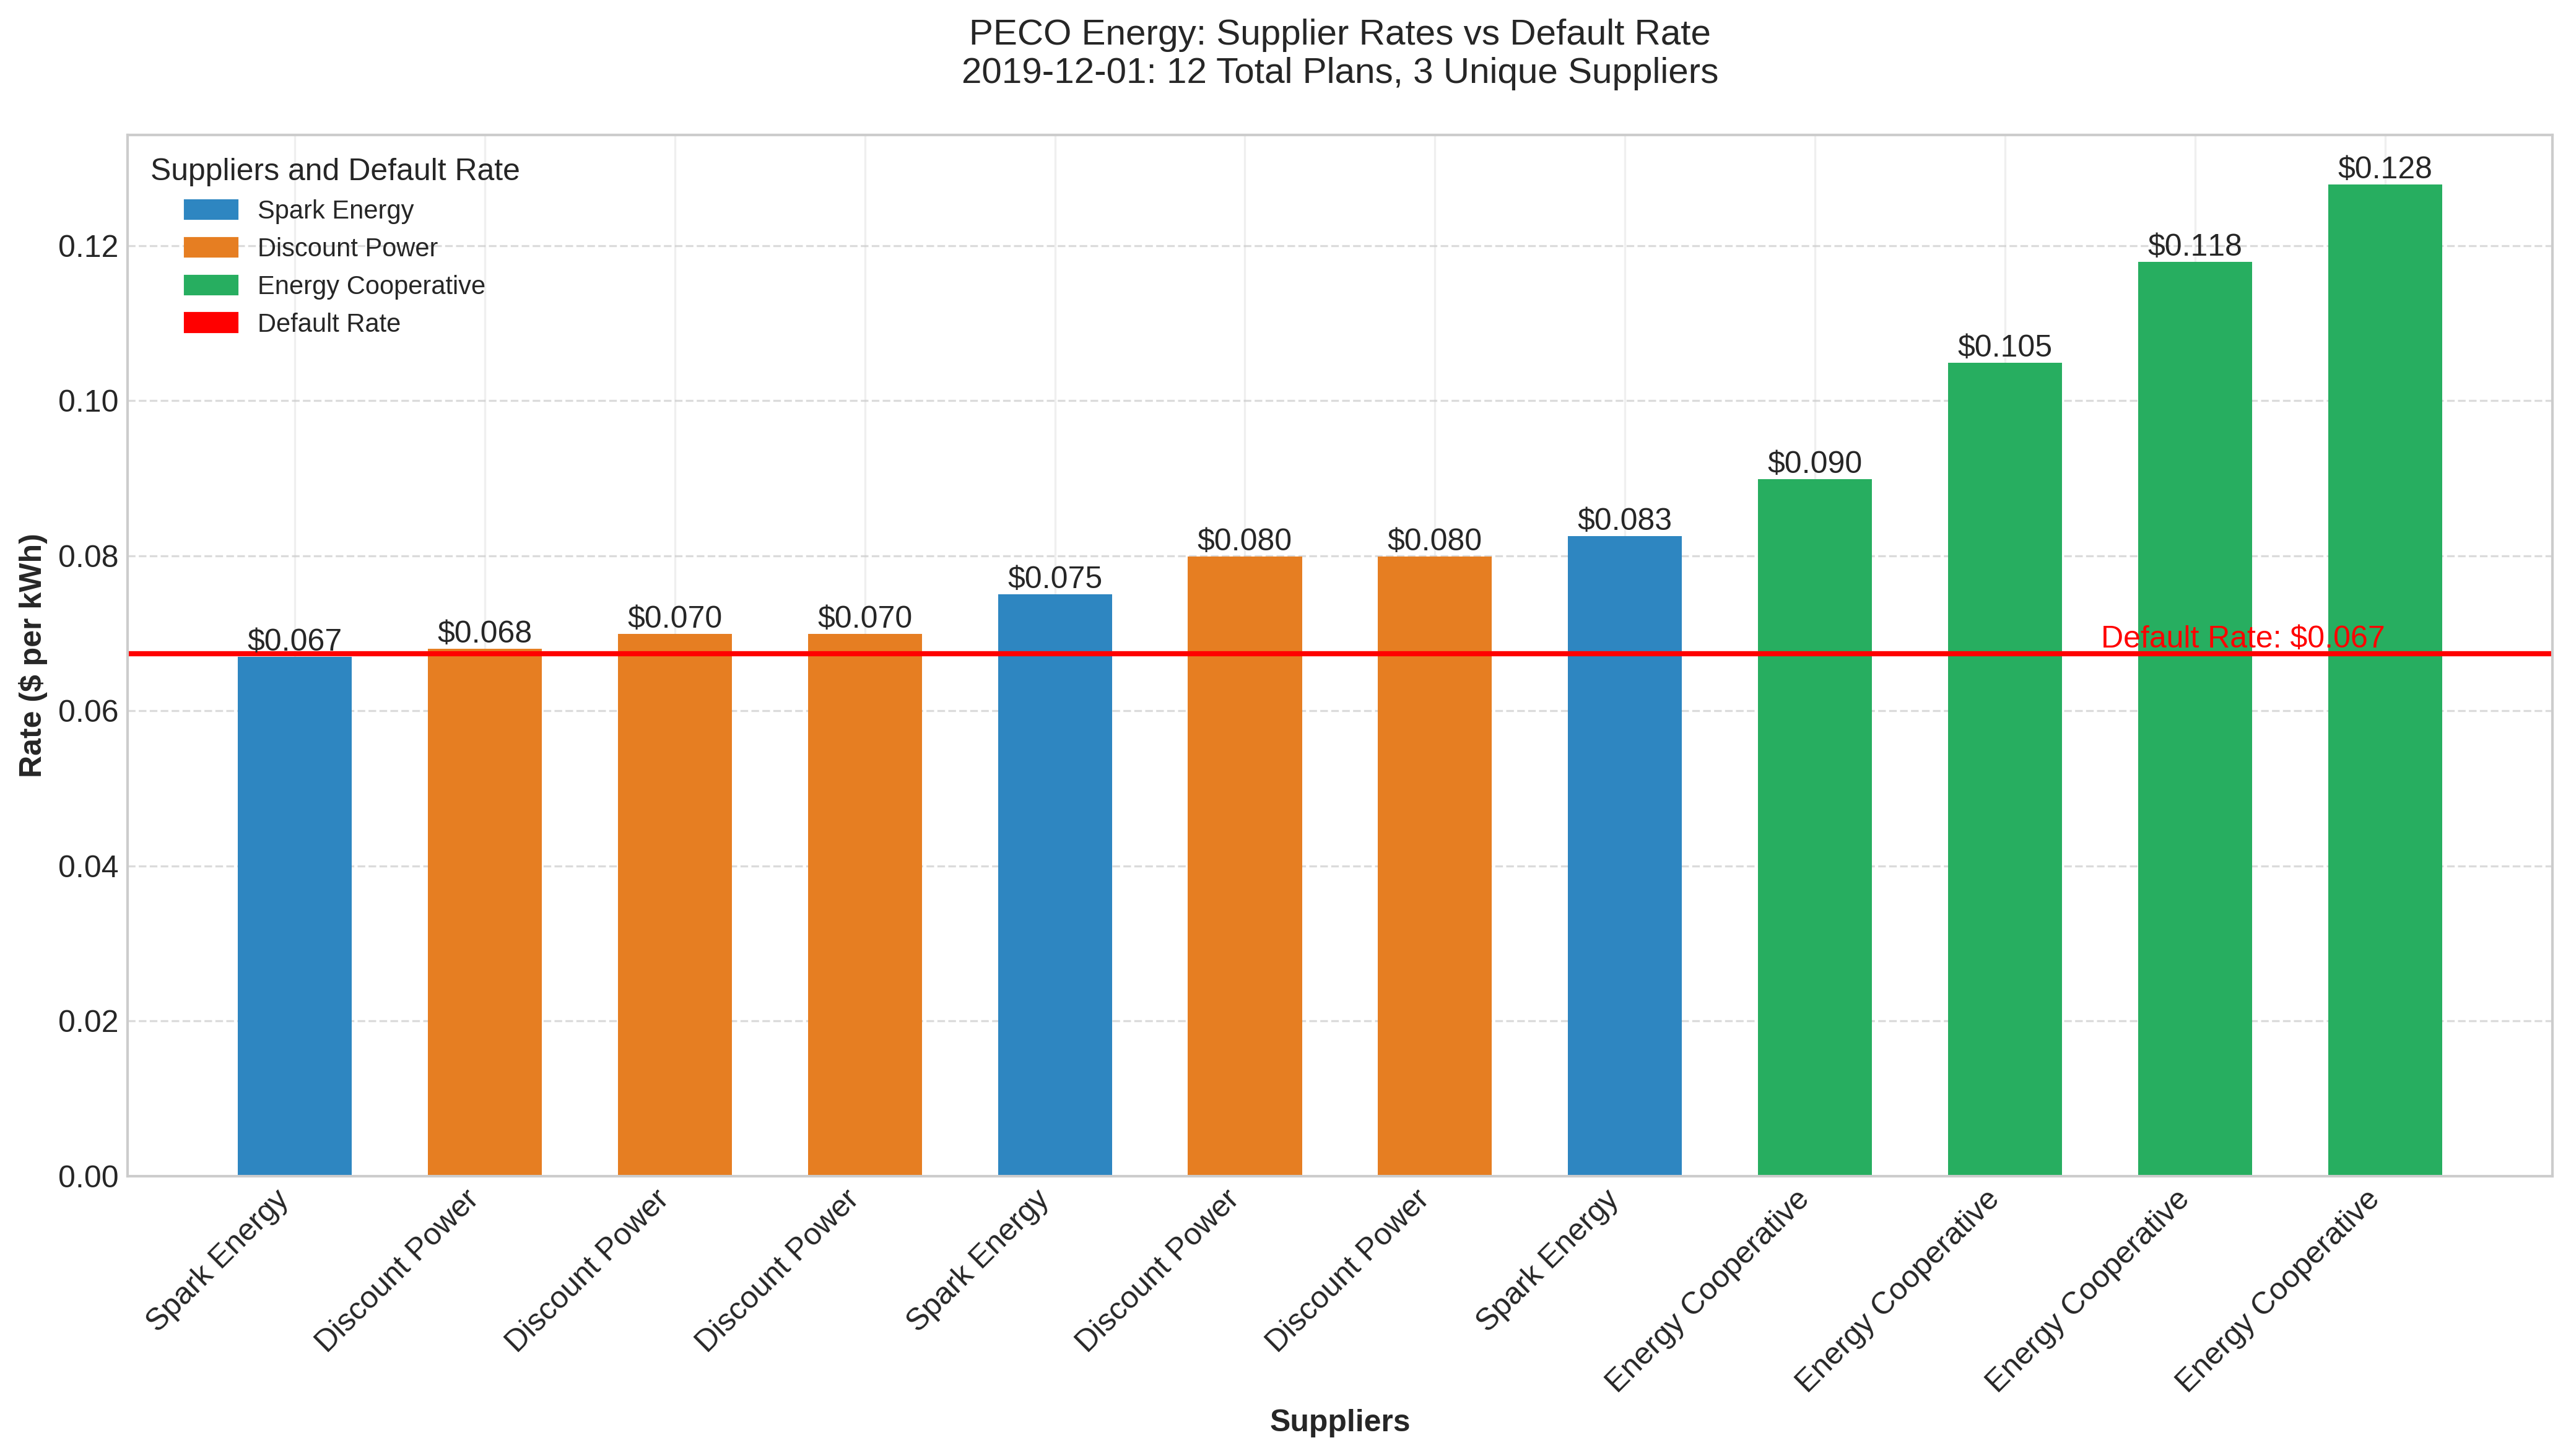

In [ ]:
# create legend handles for unique suppliers
import matplotlib.patches as mpatches

# Filter for PECO Energy from df_combined and filtered_suppliers
peco_default = df_combined[df_combined['utility_name'] == 'PECO Energy'].copy()
peco_suppliers = filtered_suppliers[filtered_suppliers['utility_name'] == 'PECO Energy'].copy()

# Count unique suppliers per day
daily_supplier_counts = peco_suppliers.groupby('created_at').agg(
    total_plans=('supplier_name', 'count'),
    unique_suppliers=('supplier_name', 'nunique')
).reset_index()
daily_supplier_counts = daily_supplier_counts.sort_values('total_plans', ascending=False)

# Get the day with the most supplier plans
max_day = daily_supplier_counts.iloc[0]['created_at']
max_plans = daily_supplier_counts.iloc[0]['total_plans']
unique_supplier_count = daily_supplier_counts.iloc[0]['unique_suppliers']

# Get data for that specific day
day_suppliers = peco_suppliers[peco_suppliers['created_at'] == max_day].copy()
default_rate = peco_default[peco_default['created_at'] == max_day]['utility_rate_amount'].iloc[0]

# Sort suppliers by rate for the bar chart
day_suppliers = day_suppliers.sort_values('plan_rate_amount')

# Define professional color palette
professional_colors = [
    '#2E86C1',  # steel blue
    '#E67E22',  # dark orange
    '#27AE60',  # emerald green
    '#8E44AD',  # dark purple
    '#C0392B',  # dark red
    '#16A085',  # green sea
    '#D35400',  # pumpkin orange
    '#2980B9',  # bright blue
    '#E74C3C',  # light red
    '#2C3E50'   # dark blue gray
]

# Create color dictionary for unique suppliers
unique_suppliers = day_suppliers['supplier_name'].unique()
color_dict = dict(zip(unique_suppliers, professional_colors[:len(unique_suppliers)]))

# Create legend handles for unique suppliers
supplier_legend = [
    mpatches.Patch(color=color_dict[supplier], label=supplier)
    for supplier in unique_suppliers
]

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# Plot supplier rates as bars with consistent colors per supplier
bars = ax.bar(
    range(len(day_suppliers)),
    day_suppliers['plan_rate_amount'],
    color=[color_dict[supplier] for supplier in day_suppliers['supplier_name']],
    width=0.6
)

# Add default rate line
ax.axhline(y=default_rate, color='red', linestyle='-', linewidth=2, label='Default Rate')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.3f}',
            ha='center', va='bottom')

# Add supplier names as x-labels in black
plt.xticks(range(len(day_suppliers)), day_suppliers['supplier_name'], rotation=45, ha='right')

# Customize plot
ax.set_title(
    f'PECO Energy: Supplier Rates vs Default Rate\n'
    f'{max_day.strftime("%Y-%m-%d")}: {max_plans} Total Plans, {unique_supplier_count} Unique Suppliers',
    fontsize=14, pad=20
)
ax.set_xlabel('Suppliers', fontsize=12, fontweight='bold')
ax.set_ylabel('Rate ($ per kWh)', fontsize=12, fontweight='bold')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add legend for default rate and suppliers
legend = supplier_legend + [mpatches.Patch(color='red', label='Default Rate')]
ax.legend(handles=legend, title='Suppliers and Default Rate', loc='upper left', fontsize=10)

# Annotate default rate value
ax.text(len(day_suppliers)-1, default_rate, f'Default Rate: ${default_rate:.3f}',
        color='red', ha='right', va='bottom')

plt.tight_layout()

# Save plot
plt.savefig(os.path.join(ANALYSIS_DIR, "peco_max_suppliers_day_comparison.png"),
            bbox_inches='tight',
            dpi=300)

plt.show()


In [ ]:
day_suppliers['supplier_name']

0.07632